# Imports

In [70]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from itertools import combinations

# preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures

# feature selection
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, mutual_info_classif, f_classif, RFE, RFECV

# decomposition
from sklearn.decomposition import PCA

# ensemble
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# naive bayes
from sklearn.naive_bayes import GaussianNB

# process classifier
from sklearn.gaussian_process import GaussianProcessClassifier

# neighbors
from sklearn.neighbors import KNeighborsClassifier

# neural networks
from sklearn.neural_network import MLPClassifier

# support vector machines
from sklearn.svm import LinearSVC, SVC

# train test split, tuning, and score validation
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV

# classification report
from sklearn.metrics import classification_report

%matplotlib inline

# Classifiers

In [71]:
classifiers = {
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=0),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=0),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100, random_state=0),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, random_state=0),
    'LogisticRegression' : LogisticRegression(solver='lbfgs', multi_class='auto', random_state=0, max_iter=500),
    'GaussianNB' : GaussianNB(),
    'GaussianProcessClassifier' : GaussianProcessClassifier(random_state=0),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'MLPClassifier' : MLPClassifier(random_state=0, max_iter=1500),
    'LinearSVC' : LinearSVC(random_state=0, max_iter=2000),
    'SVC' : SVC(gamma='scale', random_state=0),
}

# Ensembles

In [72]:
ensembles = {
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=0),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=0),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100, random_state=0),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, random_state=0),
}

# Data

In [73]:
# read training data
train = pd.read_csv("train.csv")

In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             371 non-null    int64  
 1   bone_length    371 non-null    float64
 2   rotting_flesh  371 non-null    float64
 3   hair_length    371 non-null    float64
 4   has_soul       371 non-null    float64
 5   color          371 non-null    object 
 6   type           371 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [75]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [76]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# Color

In [77]:
# get dummy color features
train = train.join(pd.get_dummies(train.color))

In [78]:
# # create empty list to hold combinations of colors
# c = []

# # create combinations of color features (min 2, max nunique colors - 1)
# for i in range(2, train.color.nunique()):
#     els = [list(x) for x in combinations(train.color.unique(), i)]
#     c.extend(els)

# # sum the combinations and add new column to train
# for i in c:
#     train['_'.join(i)] = train[i].sum(axis=1)

# EDA

## `bone_length`

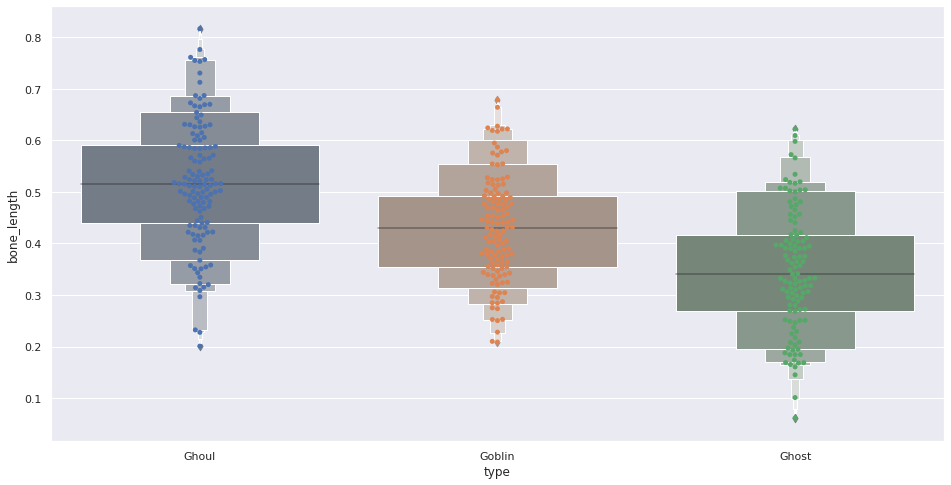

In [79]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length',
);

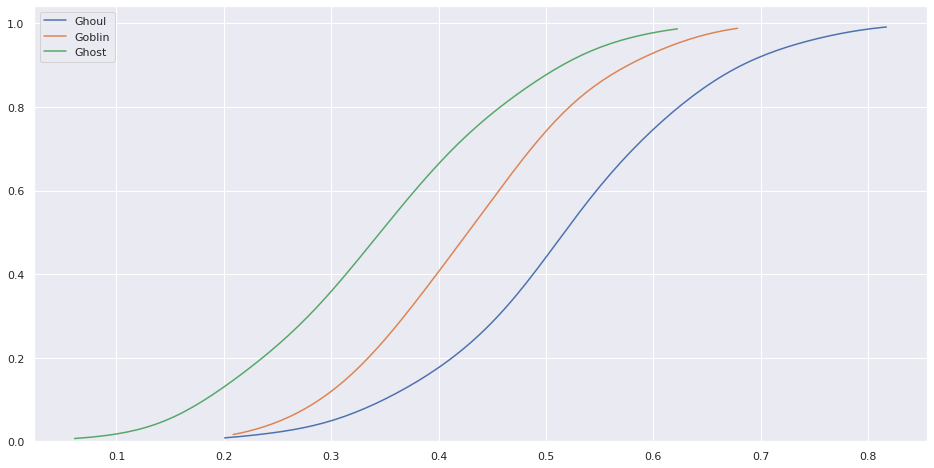

In [80]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [81]:
lower_bone_length = train.groupby([
    'type',
]).bone_length.min().sort_values()

lower_bone_length

type
Ghost     0.061032
Ghoul     0.200753
Goblin    0.208625
Name: bone_length, dtype: float64

In [82]:
train['bone_length_lower'] = train.bone_length < lower_bone_length.iloc[1]

In [83]:
upper_bone_length = train.groupby([
    'type',
]).bone_length.max().sort_values()

upper_bone_length

type
Ghost     0.622371
Goblin    0.678519
Ghoul     0.817001
Name: bone_length, dtype: float64

In [84]:
train['bone_length_upper'] = train.bone_length > upper_bone_length.iloc[1]

## `rotting_flesh`

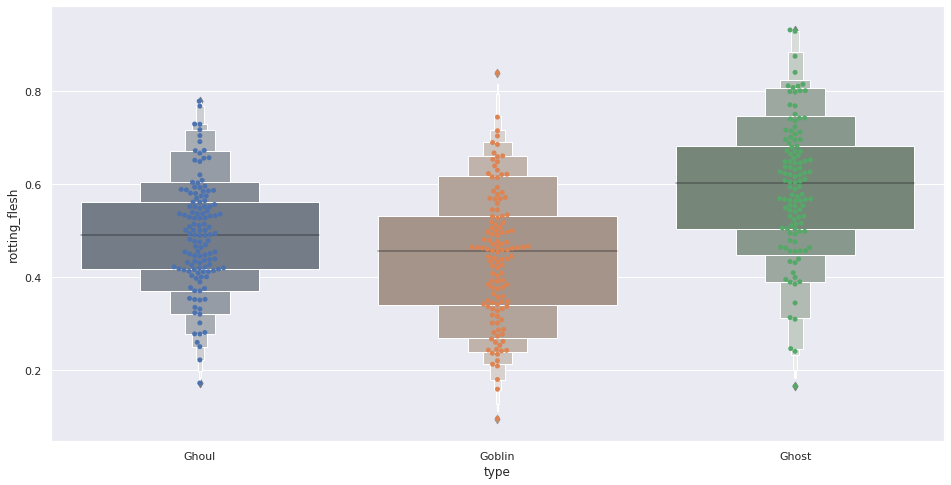

In [32]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh',
);

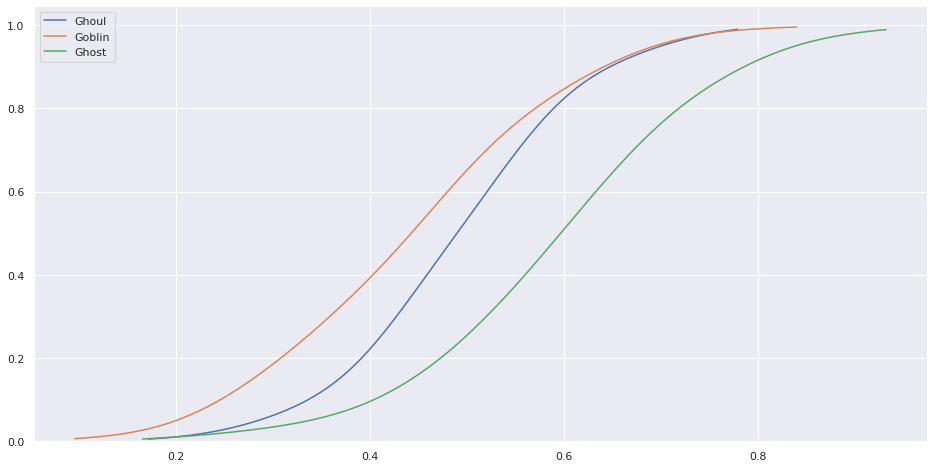

In [33]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [92]:
lower_rotting_flesh = train.groupby([
    'type',
]).rotting_flesh.min().sort_values()

lower_rotting_flesh

type
Goblin    0.095687
Ghost     0.165539
Ghoul     0.172182
Name: rotting_flesh, dtype: float64

In [93]:
train['rotting_flesh_lower'] = train.rotting_flesh < lower_rotting_flesh.iloc[1]

In [94]:
upper_rotting_flesh = train.groupby([
    'type',
]).rotting_flesh.max().sort_values()

upper_rotting_flesh

type
Ghoul     0.779153
Goblin    0.840049
Ghost     0.932466
Name: rotting_flesh, dtype: float64

In [95]:
train['rotting_flesh_upper'] = train.rotting_flesh > upper_rotting_flesh.iloc[1]

## `hair_length`

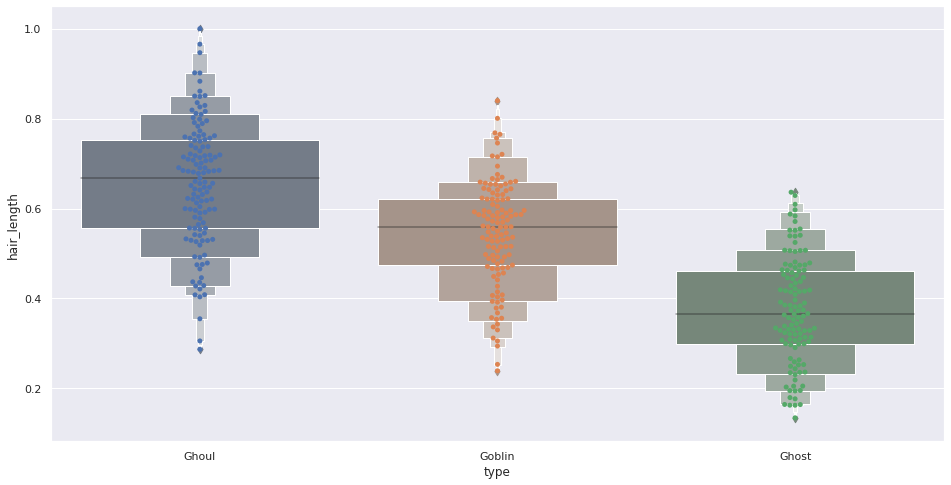

In [39]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='hair_length',
);

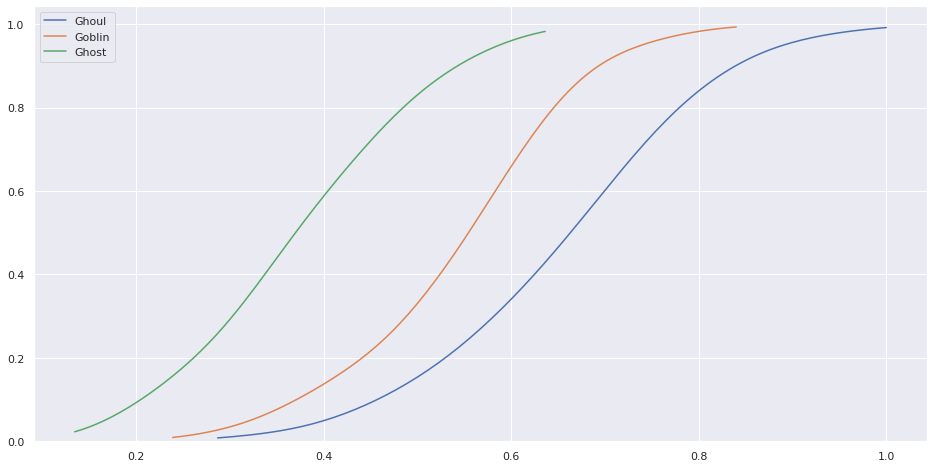

In [35]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [96]:
lower_hair_length = train.groupby([
    'type',
]).hair_length.min().sort_values()

lower_hair_length

type
Ghost     0.134600
Goblin    0.239212
Ghoul     0.287008
Name: hair_length, dtype: float64

In [97]:
train['hair_length_lower'] = train.hair_length < lower_hair_length.iloc[1]

In [98]:
upper_hair_length = train.groupby([
    'type',
]).hair_length.max().sort_values()

upper_hair_length

type
Ghost     0.636340
Goblin    0.840013
Ghoul     1.000000
Name: hair_length, dtype: float64

In [99]:
train['hair_length_upper'] = train.hair_length > upper_hair_length.iloc[1]

## `has_soul`

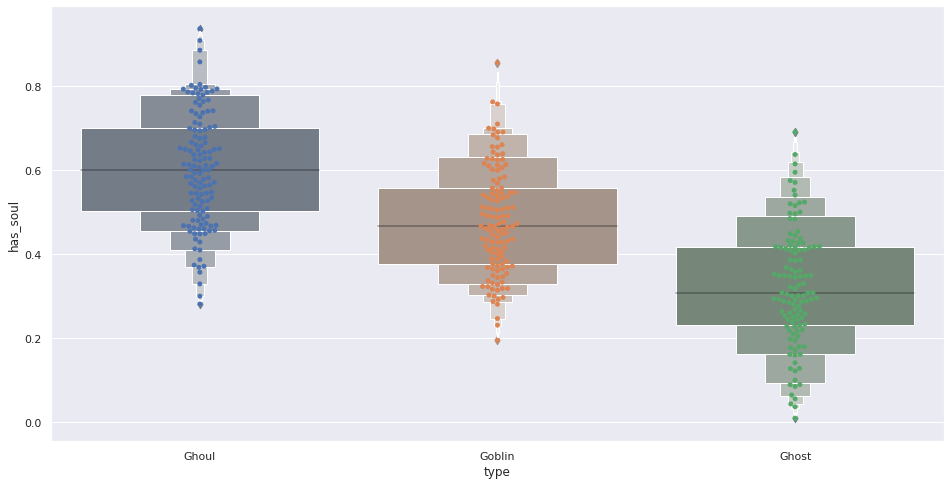

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='has_soul',
);

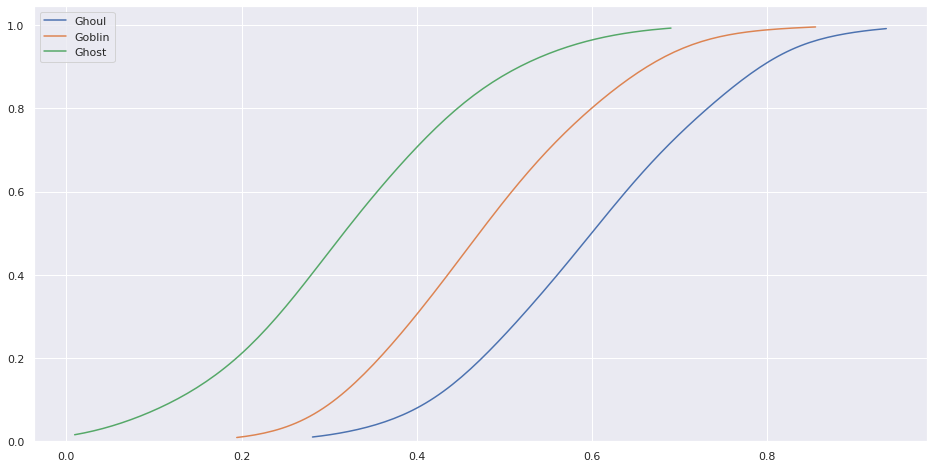

In [46]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [100]:
lower_has_soul = train.groupby([
    'type',
]).has_soul.min().sort_values()

lower_has_soul

type
Ghost     0.009402
Goblin    0.194413
Ghoul     0.280854
Name: has_soul, dtype: float64

In [101]:
train['has_soul_lower'] = train.has_soul < lower_has_soul.iloc[1]

In [102]:
upper_has_soul = train.groupby([
    'type',
]).has_soul.max().sort_values()

upper_has_soul

type
Ghost     0.689980
Goblin    0.854949
Ghoul     0.935721
Name: has_soul, dtype: float64

In [103]:
train['has_soul_upper'] = train.has_soul > upper_has_soul.iloc[1]

## Color Counts

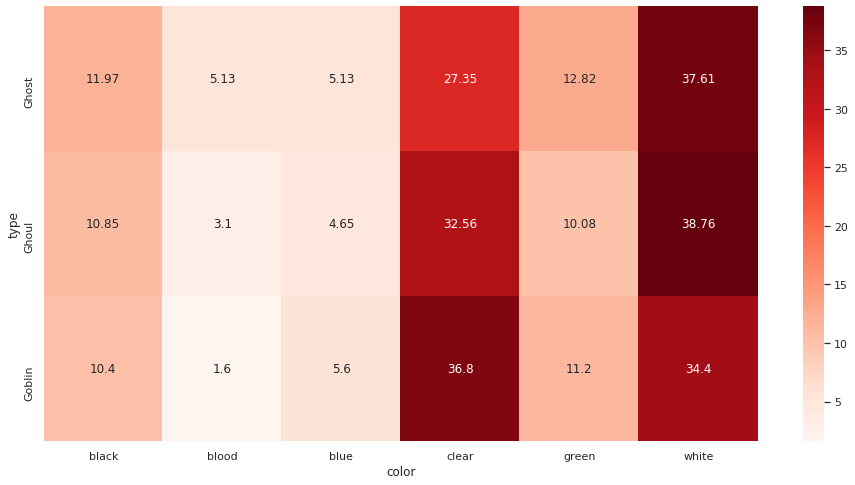

In [125]:
fig, ax = plt.subplots(figsize=(16,8))

sns.heatmap(
    data=train.groupby([
        'type',
        'color',
    ]).id.nunique().unstack().apply(lambda x : x / x.sum(), axis=1).round(4)*100,
    ax=ax,
    annot=True,
    annot_kws={
        'fontsize' : 12,
    },
    cmap='Reds',
    fmt='g',
);

### `bone_length`

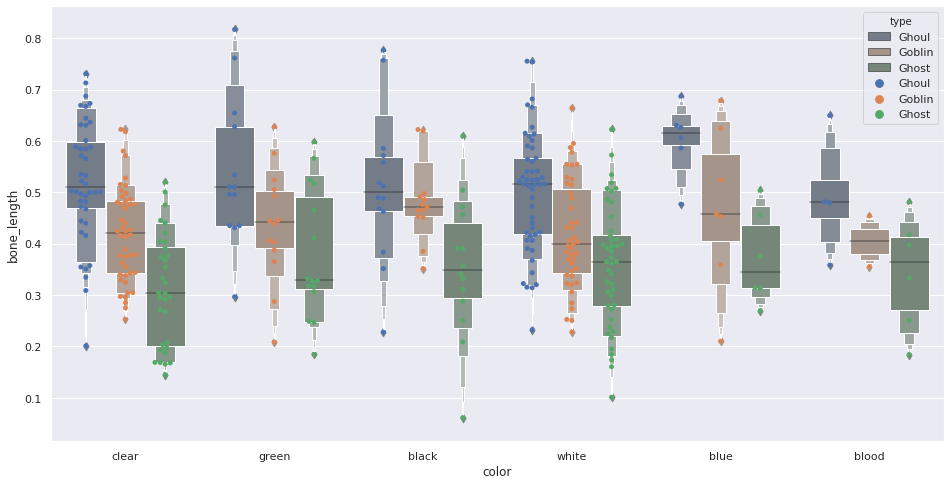

In [133]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [135]:
lower_color_bone_length = train.groupby([
    'color',
    'type',
]).bone_length.min()

lower_color_bone_length

color  type  
black  Ghost     0.061032
       Ghoul     0.227532
       Goblin    0.351559
blood  Ghost     0.184172
       Ghoul     0.358240
       Goblin    0.355313
blue   Ghost     0.269748
       Ghoul     0.476892
       Goblin    0.209997
clear  Ghost     0.145071
       Ghoul     0.200753
       Goblin    0.252733
green  Ghost     0.184383
       Ghoul     0.296605
       Goblin    0.208625
white  Ghost     0.100945
       Ghoul     0.232301
       Goblin    0.227948
Name: bone_length, dtype: float64

In [142]:
for color in lower_color_bone_length.index.levels[0]:
    lcbl = lower_color_bone_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_lower'] = (train.color == color) & (train.bone_length < lcbl)

In [144]:
upper_color_bone_length = train.groupby([
    'color',
    'type',
]).bone_length.max()

upper_color_bone_length

color  type  
black  Ghost     0.609634
       Ghoul     0.776652
       Goblin    0.622124
blood  Ghost     0.481141
       Ghoul     0.649559
       Goblin    0.453869
blue   Ghost     0.503780
       Ghoul     0.687080
       Goblin    0.678519
clear  Ghost     0.519827
       Ghoul     0.730848
       Goblin    0.622414
green  Ghost     0.598166
       Ghoul     0.817001
       Goblin    0.627652
white  Ghost     0.622371
       Ghoul     0.755298
       Goblin    0.664432
Name: bone_length, dtype: float64

In [145]:
for color in upper_color_bone_length.index.levels[0]:
    ucbl = upper_color_bone_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_upper'] = (train.color == color) & (train.bone_length > ucbl)

### `rotting_flesh`

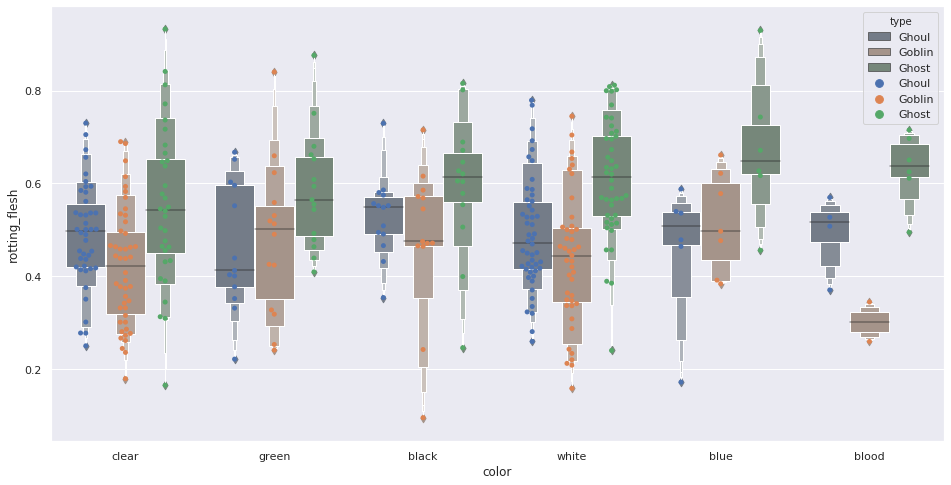

In [154]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh',
    hue='type',
    ax=ax,
    dodge=True,
);

In [155]:
lower_color_rotting_flesh = train.groupby([
    'color',
    'type',
]).rotting_flesh.min()

lower_color_rotting_flesh

color  type  
black  Ghost     0.246258
       Ghoul     0.354330
       Goblin    0.095687
blood  Ghost     0.494895
       Ghoul     0.370775
       Goblin    0.259701
blue   Ghost     0.456208
       Ghoul     0.172182
       Goblin    0.384133
clear  Ghost     0.165539
       Ghoul     0.250401
       Goblin    0.179727
green  Ghost     0.409596
       Ghoul     0.221793
       Goblin    0.241139
white  Ghost     0.240299
       Ghoul     0.259702
       Goblin    0.158742
Name: rotting_flesh, dtype: float64

In [156]:
for color in lower_color_rotting_flesh.index.levels[0]:
    lcbl = lower_color_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_lower'] = (train.color == color) & (train.rotting_flesh < lcbl)

In [157]:
upper_color_rotting_flesh = train.groupby([
    'color',
    'type',
]).rotting_flesh.max()

upper_color_rotting_flesh

color  type  
black  Ghost     0.815466
       Ghoul     0.729360
       Goblin    0.715401
blood  Ghost     0.715131
       Ghoul     0.569762
       Goblin    0.344684
blue   Ghost     0.929440
       Ghoul     0.587943
       Goblin    0.661235
clear  Ghost     0.932466
       Ghoul     0.729873
       Goblin    0.689975
green  Ghost     0.875862
       Ghoul     0.667160
       Goblin    0.840049
white  Ghost     0.811583
       Ghoul     0.779153
       Goblin    0.744830
Name: rotting_flesh, dtype: float64

In [158]:
for color in upper_color_rotting_flesh.index.levels[0]:
    ucbl = upper_color_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_upper'] = (train.color == color) & (train.rotting_flesh > ucbl)

### `hair_length`

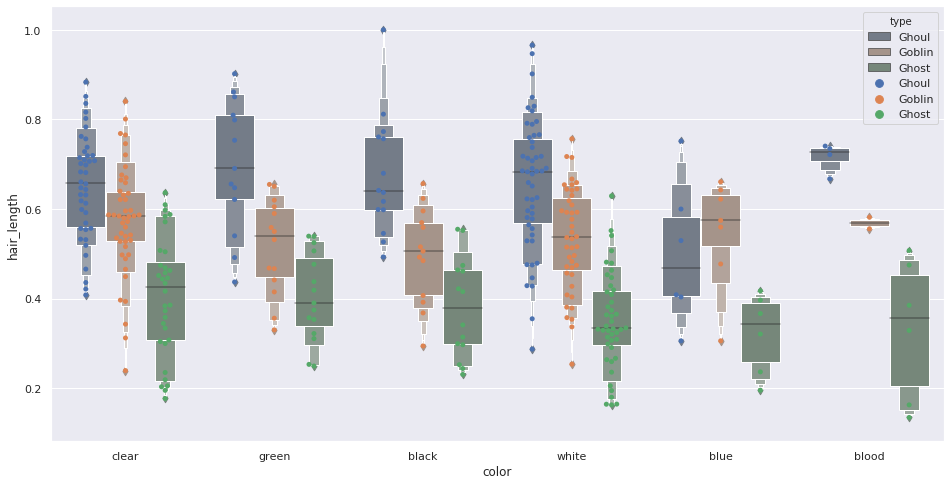

In [160]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [161]:
lower_color_hair_length = train.groupby([
    'color',
    'type',
]).hair_length.min()

lower_color_hair_length

color  type  
black  Ghost     0.230619
       Ghoul     0.492918
       Goblin    0.294214
blood  Ghost     0.134600
       Ghoul     0.667384
       Goblin    0.555728
blue   Ghost     0.195365
       Ghoul     0.305580
       Goblin    0.305594
clear  Ghost     0.176882
       Ghoul     0.408066
       Goblin    0.239212
green  Ghost     0.249337
       Ghoul     0.437047
       Goblin    0.330146
white  Ghost     0.162715
       Ghoul     0.287008
       Goblin    0.253459
Name: hair_length, dtype: float64

In [162]:
for color in lower_color_hair_length.index.levels[0]:
    lcbl = lower_color_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_lower'] = (train.color == color) & (train.hair_length < lcbl)

In [163]:
upper_color_hair_length = train.groupby([
    'color',
    'type',
]).hair_length.max()

upper_color_hair_length

color  type  
black  Ghost     0.554654
       Ghoul     1.000000
       Goblin    0.656528
blood  Ghost     0.507214
       Ghoul     0.740270
       Goblin    0.581400
blue   Ghost     0.417267
       Ghoul     0.751614
       Goblin    0.660590
clear  Ghost     0.636340
       Ghoul     0.883088
       Goblin    0.840013
green  Ghost     0.539216
       Ghoul     0.901810
       Goblin    0.654721
white  Ghost     0.629068
       Ghoul     0.965569
       Goblin    0.756629
Name: hair_length, dtype: float64

In [164]:
for color in upper_color_hair_length.index.levels[0]:
    ucbl = upper_color_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_upper'] = (train.color == color) & (train.hair_length > ucbl)

### `has_soul`

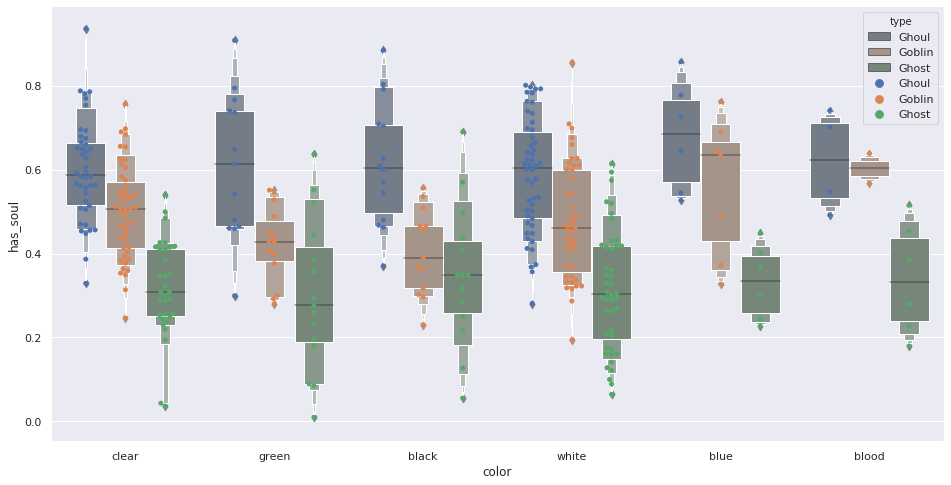

In [166]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [167]:
lower_color_has_soul = train.groupby([
    'color',
    'type',
]).has_soul.min()

lower_color_has_soul

color  type  
black  Ghost     0.055464
       Ghoul     0.370740
       Goblin    0.230523
blood  Ghost     0.179642
       Ghoul     0.491938
       Goblin    0.567843
blue   Ghost     0.227548
       Ghoul     0.526718
       Goblin    0.327212
clear  Ghost     0.036457
       Ghoul     0.328717
       Goblin    0.246347
green  Ghost     0.009402
       Ghoul     0.299511
       Goblin    0.280324
white  Ghost     0.064468
       Ghoul     0.280854
       Goblin    0.194413
Name: has_soul, dtype: float64

In [168]:
for color in lower_color_has_soul.index.levels[0]:
    lcbl = lower_color_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_has_soul_lower'] = (train.color == color) & (train.has_soul < lcbl)

In [169]:
upper_color_has_soul = train.groupby([
    'color',
    'type',
]).has_soul.max()

upper_color_has_soul

color  type  
black  Ghost     0.689980
       Ghoul     0.884464
       Goblin    0.556500
blood  Ghost     0.514944
       Ghoul     0.740579
       Goblin    0.638232
blue   Ghost     0.447946
       Ghoul     0.856757
       Goblin    0.761621
clear  Ghost     0.539800
       Ghoul     0.935721
       Goblin    0.756766
green  Ghost     0.636438
       Ghoul     0.907712
       Goblin    0.550968
white  Ghost     0.614158
       Ghoul     0.800853
       Goblin    0.854949
Name: has_soul, dtype: float64

In [170]:
for color in upper_color_has_soul.index.levels[0]:
    ucbl = upper_color_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_has_soul_upper'] = (train.color == color) & (train.has_soul > ucbl)

## Continuous Interactions

### 2-way

In [ ]:
train['bone_length_rotting_flesh'] = train.bone_length * train.rotting_flesh

train['bone_length_hair_length'] = train.bone_length * train.hair_length

train['bone_length_has_soul'] = train.bone_length * train.has_soul

train['rotting_flesh_hair_length'] = train.rotting_flesh * train.hair_length

train['rotting_flesh_has_soul'] = train.rotting_flesh * train.has_soul

train['hair_length_has_soul'] = train.hair_length * train.has_soul

#### `bone_length_rotting_flesh`

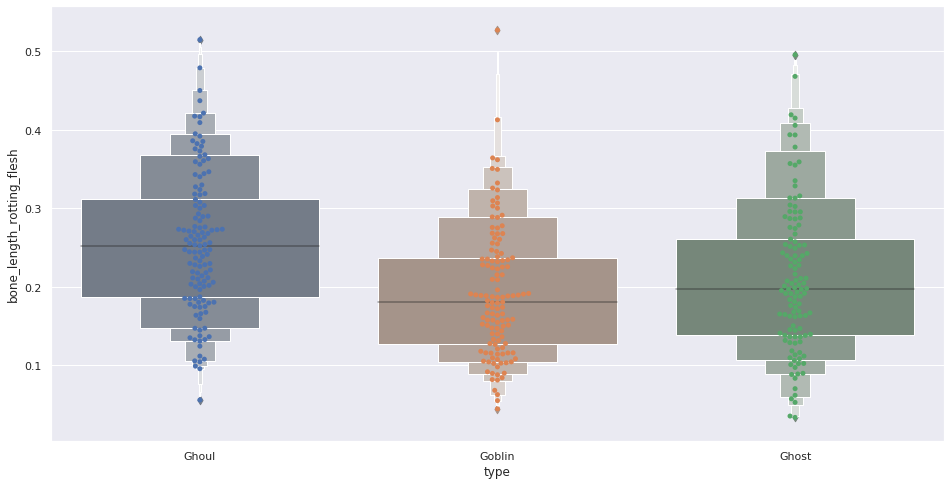

In [181]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh',
);

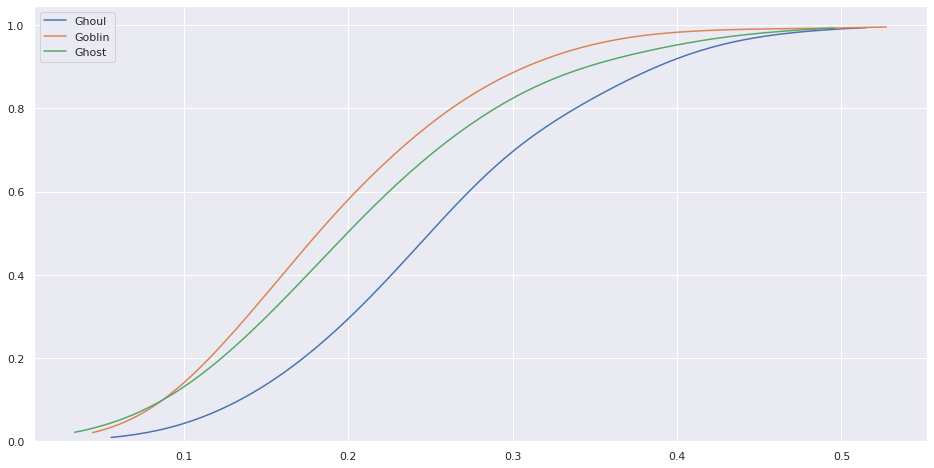

In [182]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [183]:
lower_bone_length_rotting_flesh = train.groupby([
    'type',
]).bone_length_rotting_flesh.min().sort_values()

lower_bone_length_rotting_flesh

type
Ghost     0.033617
Goblin    0.044535
Ghoul     0.055798
Name: bone_length_rotting_flesh, dtype: float64

In [184]:
train['bone_length_rotting_flesh_lower'] = train.bone_length_rotting_flesh < lower_bone_length_rotting_flesh.iloc[1]

In [185]:
upper_bone_length_rotting_flesh = train.groupby([
    'type',
]).bone_length_rotting_flesh.max().sort_values()

upper_bone_length_rotting_flesh

type
Ghost     0.495840
Ghoul     0.515027
Goblin    0.527259
Name: bone_length_rotting_flesh, dtype: float64

In [186]:
train['bone_length_rotting_flesh_upper'] = train.bone_length_rotting_flesh > upper_bone_length_rotting_flesh.iloc[1]

#### `bone_length_hair_length`

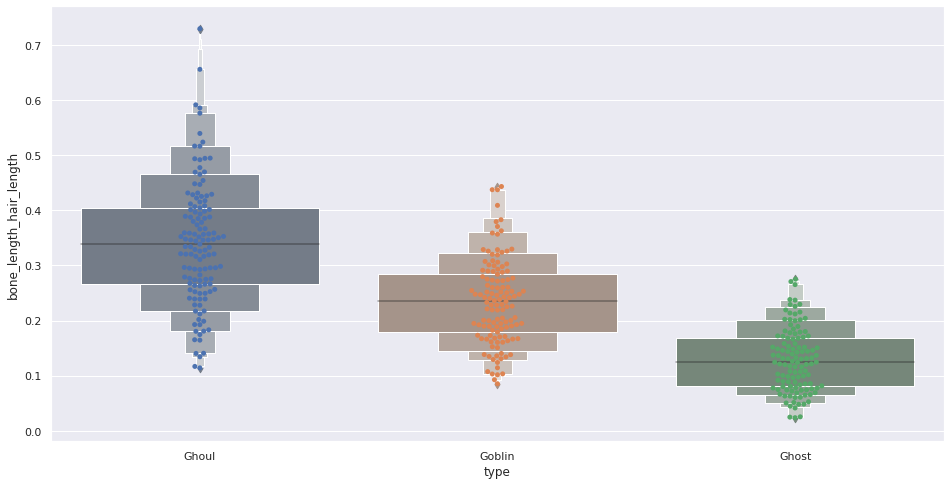

In [188]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_hair_length',
);

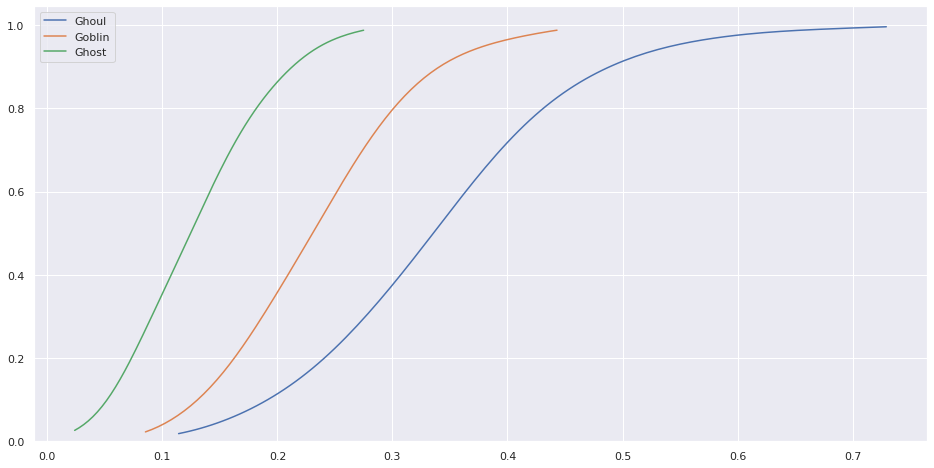

In [189]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [190]:
lower_bone_length_hair_length = train.groupby([
    'type',
]).bone_length_hair_length.min().sort_values()

lower_bone_length_hair_length

type
Ghost     0.023789
Goblin    0.085308
Ghoul     0.114135
Name: bone_length_hair_length, dtype: float64

In [191]:
train['bone_length_hair_length_lower'] = train.bone_length_hair_length < lower_bone_length_hair_length.iloc[1]

In [192]:
upper_bone_length_hair_length = train.groupby([
    'type',
]).bone_length_hair_length.max().sort_values()

upper_bone_length_hair_length

type
Ghost     0.274952
Goblin    0.443054
Ghoul     0.729292
Name: bone_length_hair_length, dtype: float64

In [193]:
train['bone_length_hair_length_upper'] = train.bone_length_hair_length > upper_bone_length_hair_length.iloc[1]

#### `bone_length_has_soul`

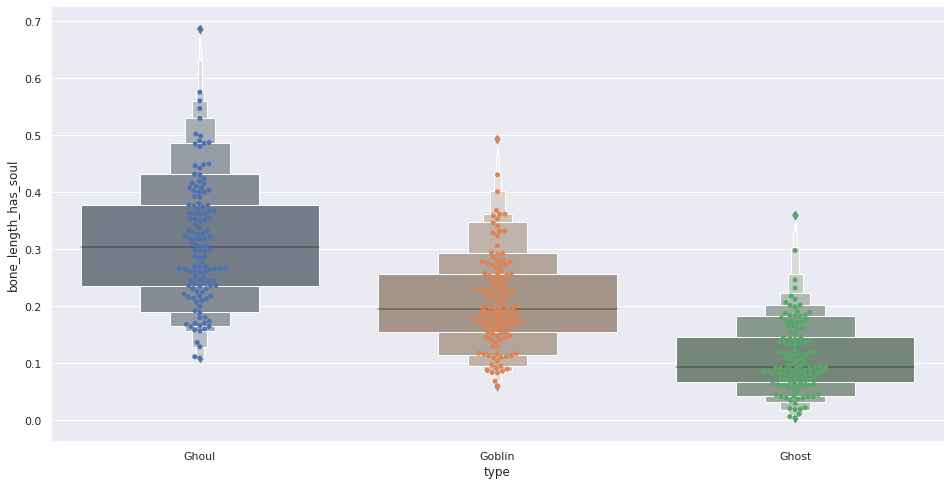

In [195]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_has_soul',
);

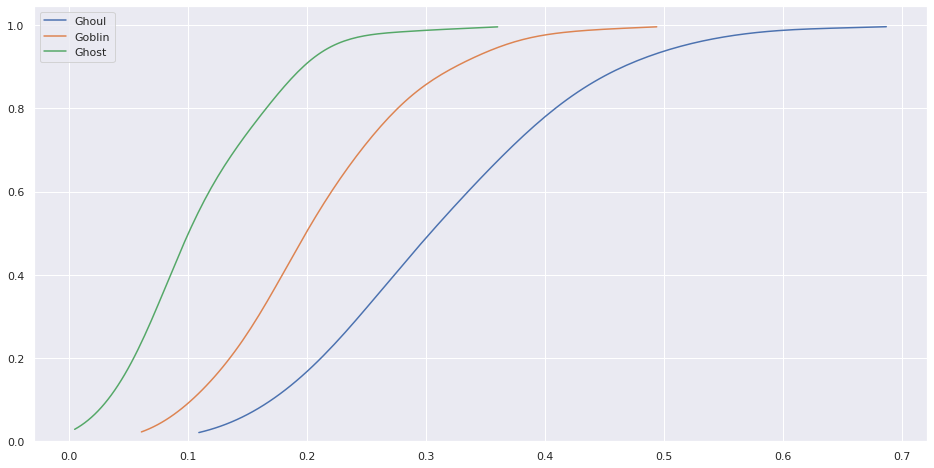

In [196]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [197]:
lower_bone_length_has_soul = train.groupby([
    'type',
]).bone_length_has_soul.min().sort_values()

lower_bone_length_has_soul

type
Ghost     0.004859
Goblin    0.060946
Ghoul     0.109226
Name: bone_length_has_soul, dtype: float64

In [198]:
train['bone_length_has_soul_lower'] = train.bone_length_has_soul < lower_bone_length_has_soul.iloc[1]

In [199]:
upper_bone_length_has_soul = train.groupby([
    'type',
]).bone_length_has_soul.max().sort_values()

upper_bone_length_has_soul

type
Ghost     0.360298
Goblin    0.493997
Ghoul     0.686921
Name: bone_length_has_soul, dtype: float64

In [200]:
train['bone_length_has_soul_upper'] = train.bone_length_has_soul > upper_bone_length_has_soul.iloc[1]

#### `rotting_flesh_hair_length`

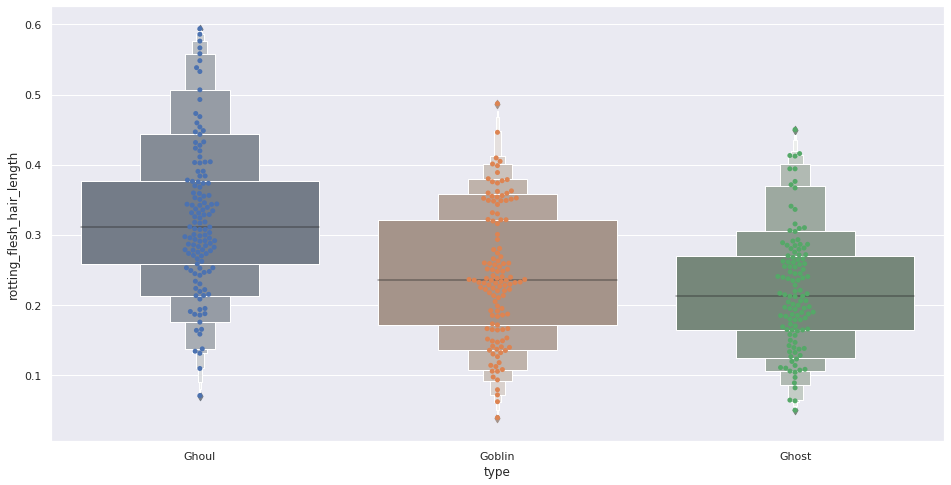

In [202]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length',
);

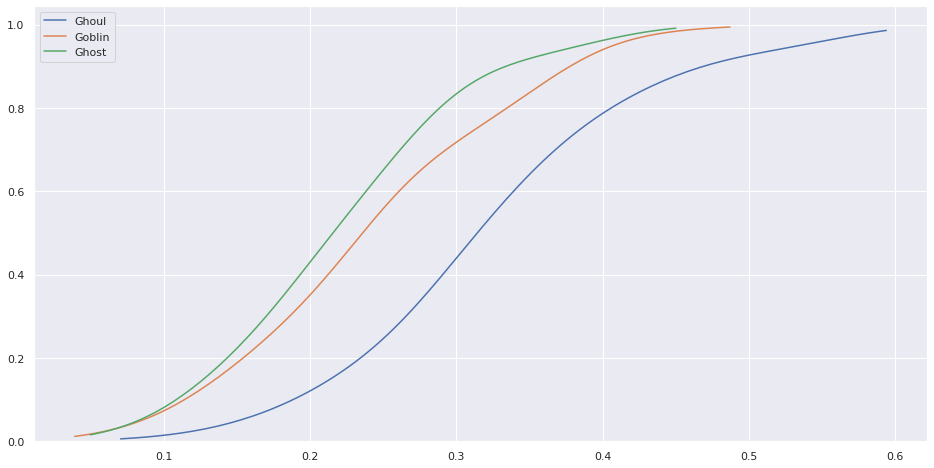

In [203]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [204]:
lower_rotting_flesh_hair_length = train.groupby([
    'type',
]).rotting_flesh_hair_length.min().sort_values()

lower_rotting_flesh_hair_length

type
Goblin    0.038924
Ghost     0.049580
Ghoul     0.070323
Name: rotting_flesh_hair_length, dtype: float64

In [205]:
train['rotting_flesh_hair_length_lower'] = train.rotting_flesh_hair_length < lower_rotting_flesh_hair_length.iloc[1]

In [206]:
upper_rotting_flesh_hair_length = train.groupby([
    'type',
]).rotting_flesh_hair_length.max().sort_values()

upper_rotting_flesh_hair_length

type
Ghost     0.450047
Goblin    0.487073
Ghoul     0.593954
Name: rotting_flesh_hair_length, dtype: float64

In [207]:
train['rotting_flesh_hair_length_upper'] = train.rotting_flesh_hair_length > upper_rotting_flesh_hair_length.iloc[1]

#### `rotting_flesh_has_soul`

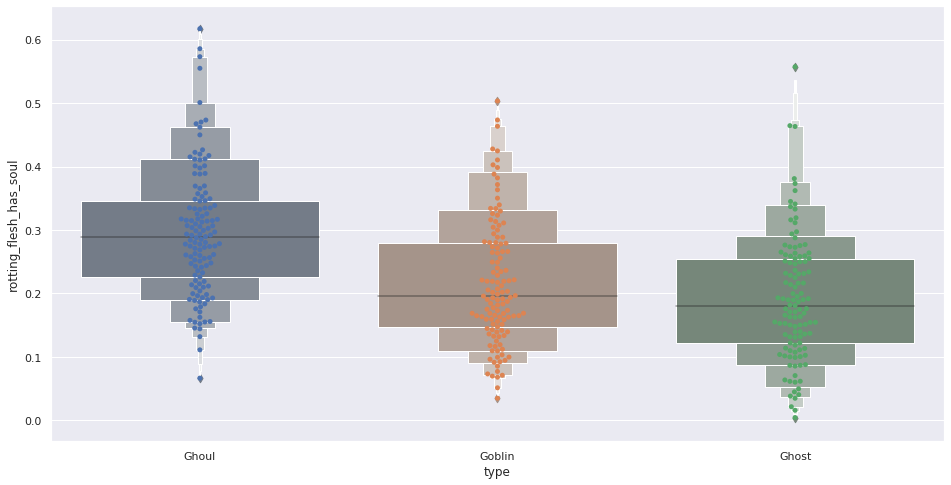

In [209]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_has_soul',
);

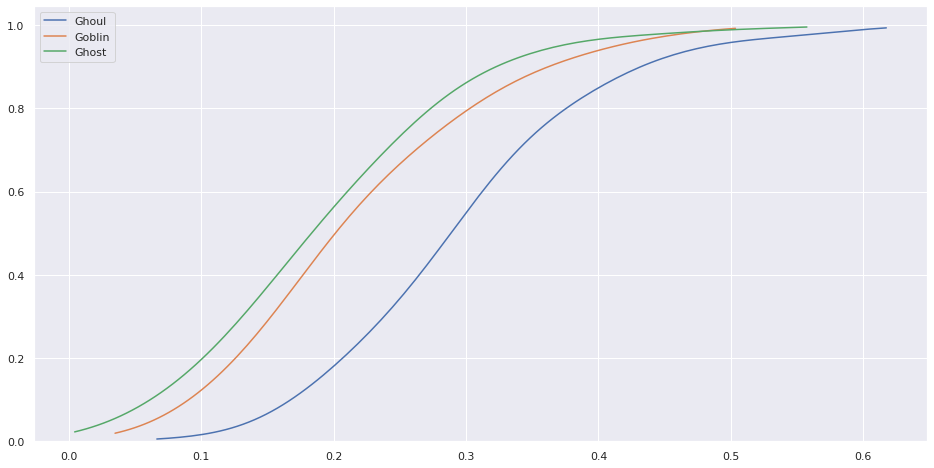

In [210]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [211]:
lower_rotting_flesh_has_soul = train.groupby([
    'type',
]).rotting_flesh_has_soul.min().sort_values()

lower_rotting_flesh_has_soul

type
Ghost     0.004360
Goblin    0.034863
Ghoul     0.066430
Name: rotting_flesh_has_soul, dtype: float64

In [212]:
train['rotting_flesh_has_soul_lower'] = train.rotting_flesh_has_soul < lower_rotting_flesh_has_soul.iloc[1]

In [213]:
upper_rotting_flesh_has_soul = train.groupby([
    'type',
]).rotting_flesh_has_soul.max().sort_values()

upper_rotting_flesh_has_soul

type
Goblin    0.503476
Ghost     0.557432
Ghoul     0.617408
Name: rotting_flesh_has_soul, dtype: float64

In [214]:
train['rotting_flesh_has_soul_upper'] = train.rotting_flesh_has_soul > upper_rotting_flesh_has_soul.iloc[1]

#### `hair_length_has_soul`

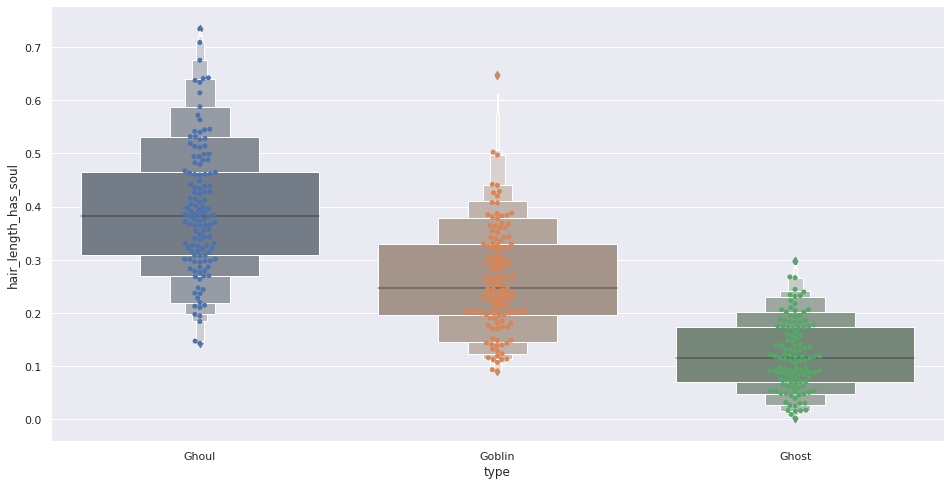

In [216]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='hair_length_has_soul',
);

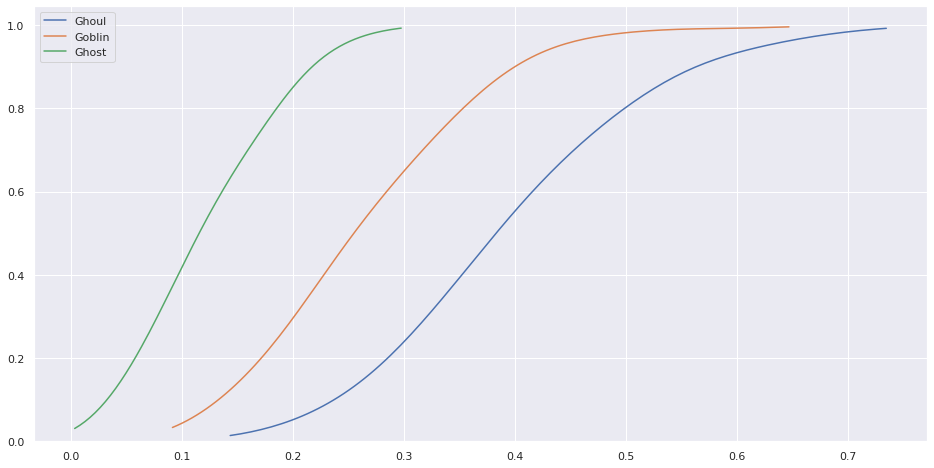

In [217]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [218]:
lower_hair_length_has_soul = train.groupby([
    'type',
]).hair_length_has_soul.min().sort_values()

lower_hair_length_has_soul

type
Ghost     0.003026
Goblin    0.091167
Ghoul     0.143227
Name: hair_length_has_soul, dtype: float64

In [219]:
train['hair_length_has_soul_lower'] = train.hair_length_has_soul < lower_hair_length_has_soul.iloc[1]

In [220]:
upper_hair_length_has_soul = train.groupby([
    'type',
]).hair_length_has_soul.max().sort_values()

upper_hair_length_has_soul

type
Ghost     0.297361
Goblin    0.646879
Ghoul     0.734639
Name: hair_length_has_soul, dtype: float64

In [221]:
train['hair_length_has_soul_upper'] = train.hair_length_has_soul > upper_hair_length_has_soul.iloc[1]

### 3-way

In [ ]:
train['bone_length_rotting_flesh_hair_length'] = train.bone_length_rotting_flesh * train.hair_length

train['bone_length_rotting_flesh_has_soul'] = train.bone_length_rotting_flesh * train.has_soul

train['bone_length_hair_length_has_soul'] = train.bone_length_hair_length * train.has_soul

train['rotting_flesh_hair_length_has_soul'] = train.rotting_flesh_hair_length * train.has_soul

#### `bone_length_rotting_flesh_hair_length`

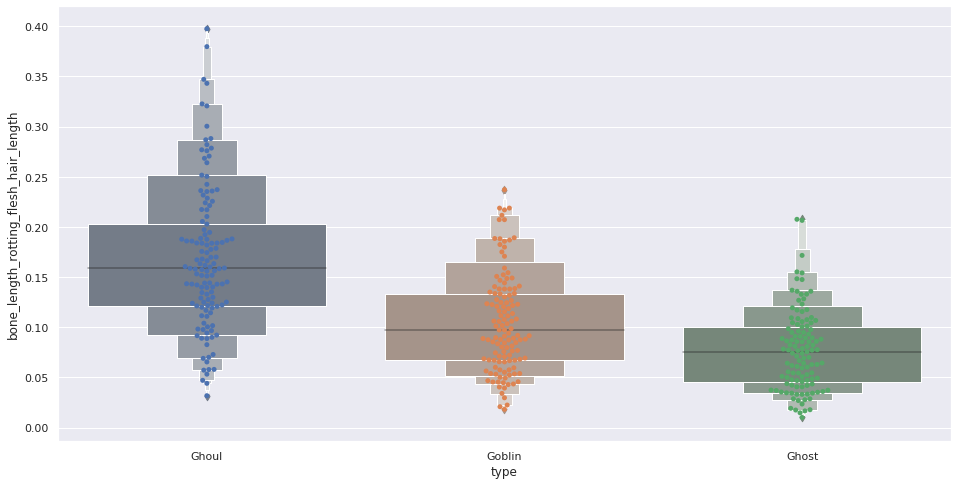

In [229]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length',
);

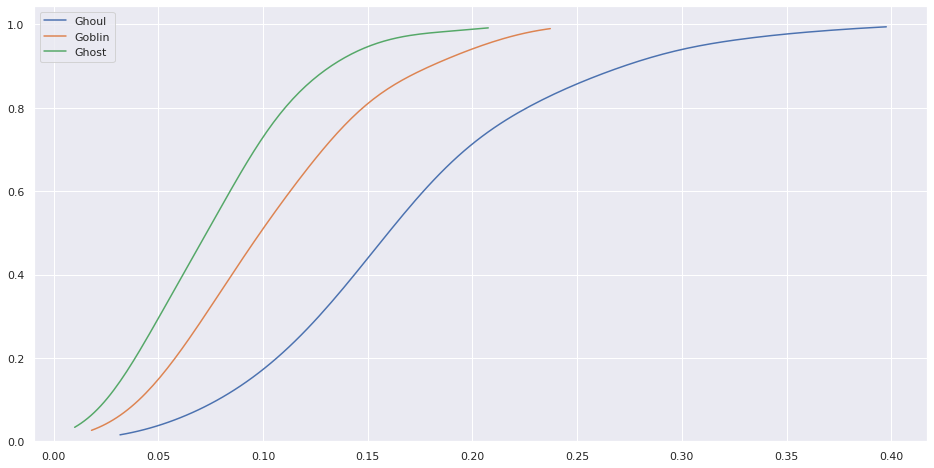

In [230]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_hair_length'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [231]:
lower_bone_length_rotting_flesh_hair_length = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length.min().sort_values()

lower_bone_length_rotting_flesh_hair_length

type
Ghost     0.010068
Goblin    0.018116
Ghoul     0.031723
Name: bone_length_rotting_flesh_hair_length, dtype: float64

In [232]:
train['bone_length_rotting_flesh_hair_length_lower'] = train.bone_length_rotting_flesh_hair_length < lower_bone_length_rotting_flesh_hair_length.iloc[1]

In [233]:
upper_bone_length_rotting_flesh_hair_length = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length.max().sort_values()

upper_bone_length_rotting_flesh_hair_length

type
Ghost     0.207555
Goblin    0.237175
Ghoul     0.397604
Name: bone_length_rotting_flesh_hair_length, dtype: float64

In [234]:
train['bone_length_rotting_flesh_hair_length_upper'] = train.bone_length_rotting_flesh_hair_length > upper_bone_length_rotting_flesh_hair_length.iloc[1]

#### `bone_length_rotting_flesh_has_soul`

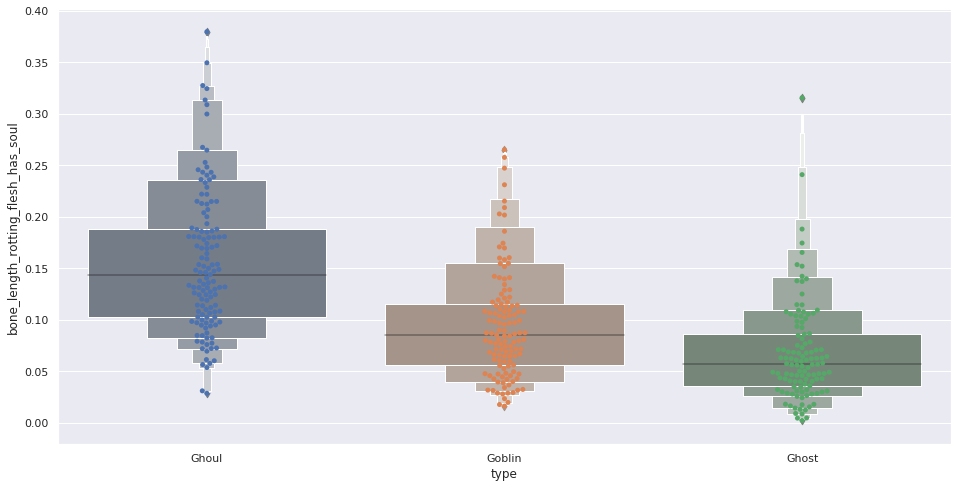

In [235]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_has_soul',
);

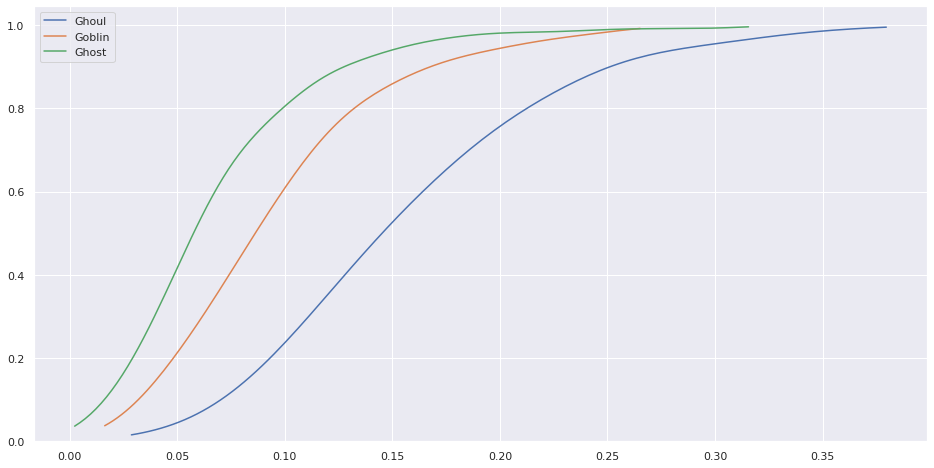

In [236]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [237]:
lower_bone_length_rotting_flesh_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_has_soul.min().sort_values()

lower_bone_length_rotting_flesh_has_soul

type
Ghost     0.002253
Goblin    0.016226
Ghoul     0.028643
Name: bone_length_rotting_flesh_has_soul, dtype: float64

In [238]:
train['bone_length_rotting_flesh_has_soul_lower'] = train.bone_length_rotting_flesh_has_soul < lower_bone_length_rotting_flesh_has_soul.iloc[1]

In [239]:
upper_bone_length_rotting_flesh_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_has_soul.max().sort_values()

upper_bone_length_rotting_flesh_has_soul

type
Goblin    0.265184
Ghost     0.315571
Ghoul     0.379644
Name: bone_length_rotting_flesh_has_soul, dtype: float64

In [240]:
train['bone_length_rotting_flesh_has_soul_upper'] = train.bone_length_rotting_flesh_has_soul > upper_bone_length_rotting_flesh_has_soul.iloc[1]

#### `bone_length_hair_length_has_soul`

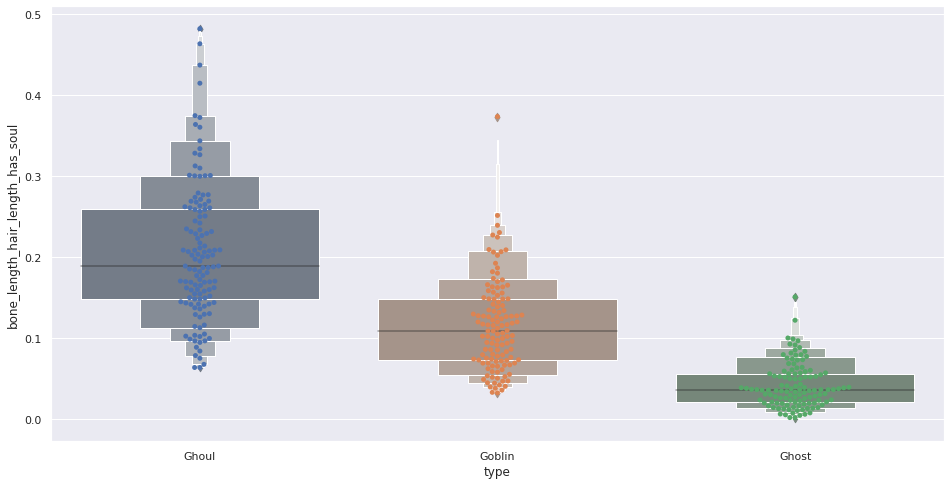

In [241]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_hair_length_has_soul',
);

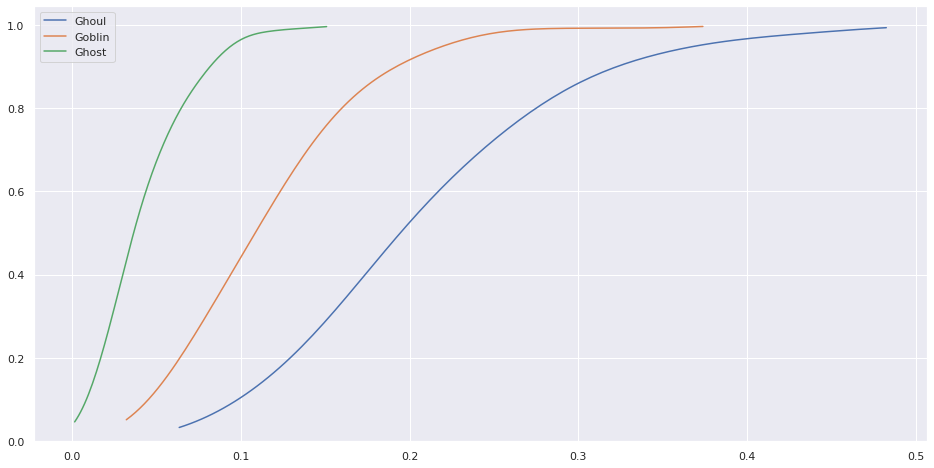

In [242]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [243]:
lower_bone_length_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_hair_length_has_soul.min().sort_values()

lower_bone_length_hair_length_has_soul

type
Ghost     0.001534
Goblin    0.032133
Ghoul     0.063476
Name: bone_length_hair_length_has_soul, dtype: float64

In [244]:
train['bone_length_hair_length_has_soul_lower'] = train.bone_length_hair_length_has_soul < lower_bone_length_hair_length_has_soul.iloc[1]

In [245]:
upper_bone_length_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_hair_length_has_soul.max().sort_values()

upper_bone_length_hair_length_has_soul

type
Ghost     0.150818
Goblin    0.373773
Ghoul     0.482434
Name: bone_length_hair_length_has_soul, dtype: float64

In [246]:
train['bone_length_hair_length_has_soul_upper'] = train.bone_length_hair_length_has_soul > upper_bone_length_hair_length_has_soul.iloc[1]

#### `rotting_flesh_hair_length_has_soul`

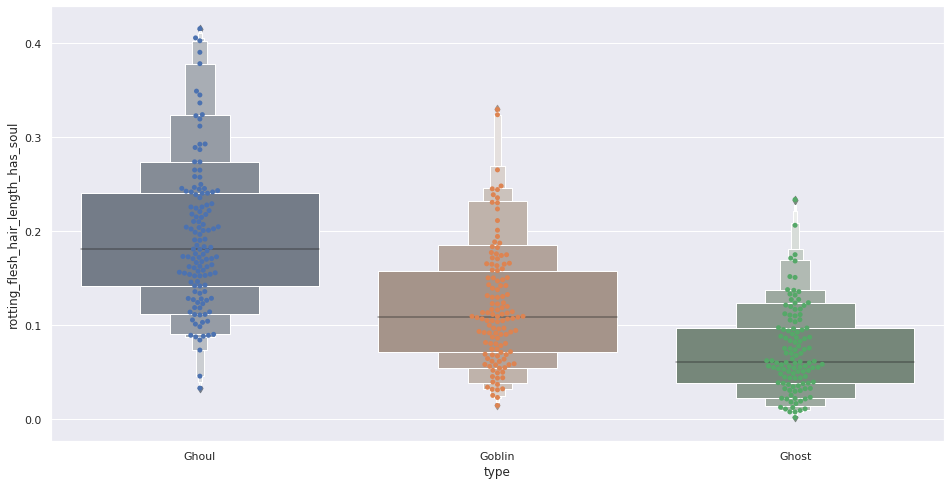

In [248]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='rotting_flesh_hair_length_has_soul',
);

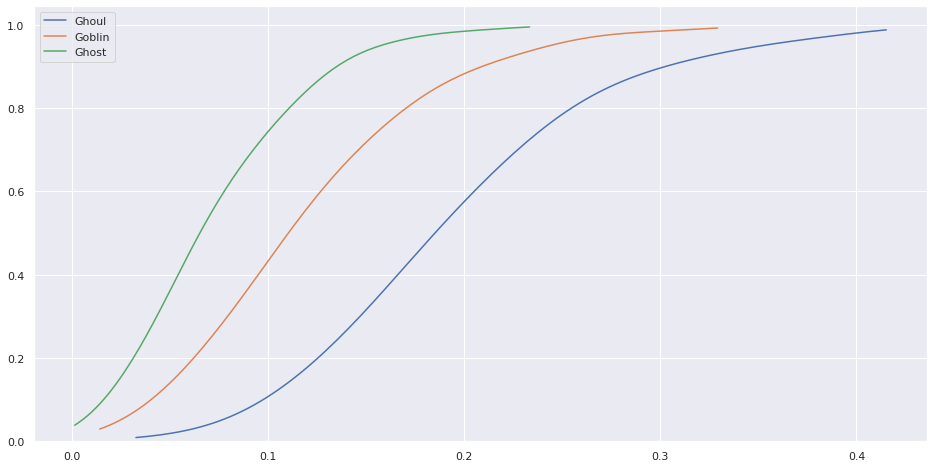

In [249]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'rotting_flesh_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [250]:
lower_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).rotting_flesh_hair_length_has_soul.min().sort_values()

lower_rotting_flesh_hair_length_has_soul

type
Ghost     0.001403
Goblin    0.014182
Ghoul     0.032652
Name: rotting_flesh_hair_length_has_soul, dtype: float64

In [251]:
train['rotting_flesh_hair_length_has_soul_lower'] = train.rotting_flesh_hair_length_has_soul < lower_rotting_flesh_hair_length_has_soul.iloc[1]

In [252]:
upper_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).rotting_flesh_hair_length_has_soul.max().sort_values()

upper_rotting_flesh_hair_length_has_soul

type
Ghost     0.233337
Goblin    0.329242
Ghoul     0.415250
Name: rotting_flesh_hair_length_has_soul, dtype: float64

In [253]:
train['rotting_flesh_hair_length_has_soul_upper'] = train.rotting_flesh_hair_length_has_soul > upper_rotting_flesh_hair_length_has_soul.iloc[1]

### 4-way

In [174]:
train['bone_length_rotting_flesh_hair_length_has_soul'] = train.bone_length_rotting_flesh_hair_length * train.has_soul

#### `bone_length_rotting_flesh_hair_length_has_soul`

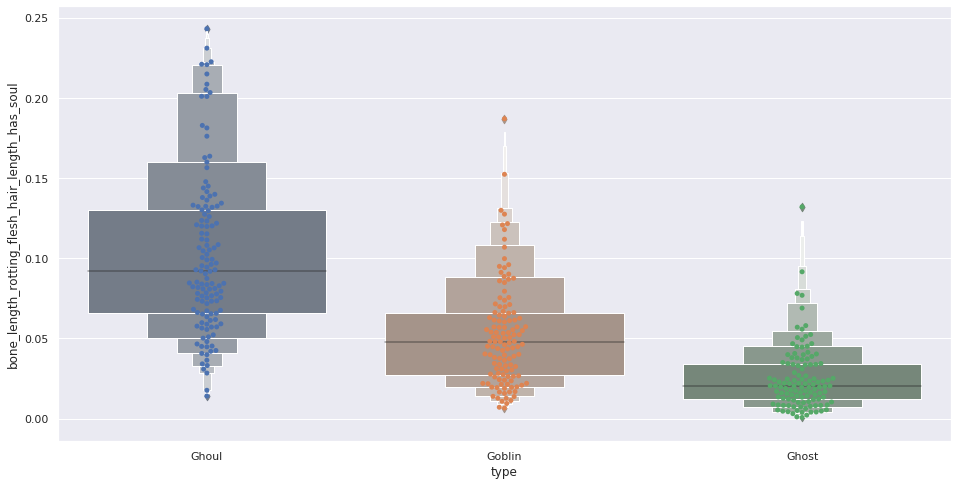

In [254]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    saturation=0.2
)

sns.swarmplot(
    data=train,
    x='type',
    y='bone_length_rotting_flesh_hair_length_has_soul',
);

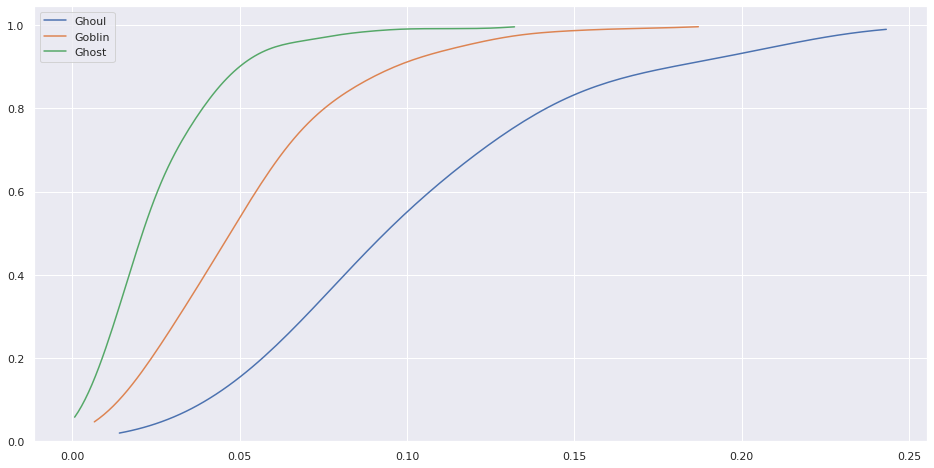

In [255]:
fig, ax = plt.subplots(figsize=(16,8))

for ggg in train.type.unique():

    sns.kdeplot(
        data=train.loc[train.type == ggg, 'bone_length_rotting_flesh_hair_length_has_soul'],
        cumulative=True,
        cut=0,
        label=ggg,
        ax=ax,
    )

In [256]:
lower_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.min().sort_values()

lower_bone_length_rotting_flesh_hair_length_has_soul

type
Ghost     0.000725
Goblin    0.006601
Ghoul     0.014079
Name: bone_length_rotting_flesh_hair_length_has_soul, dtype: float64

In [257]:
train['bone_length_rotting_flesh_hair_length_has_soul_lower'] = train.bone_length_rotting_flesh_hair_length_has_soul < lower_bone_length_rotting_flesh_hair_length_has_soul.iloc[1]

In [258]:
upper_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.max().sort_values()

upper_bone_length_rotting_flesh_hair_length_has_soul

type
Ghost     0.132096
Goblin    0.187013
Ghoul     0.243153
Name: bone_length_rotting_flesh_hair_length_has_soul, dtype: float64

In [259]:
train['bone_length_rotting_flesh_hair_length_has_soul_upper'] = train.bone_length_rotting_flesh_hair_length_has_soul > upper_bone_length_rotting_flesh_hair_length_has_soul.iloc[1]

In [260]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,black,blood,blue,...,bone_length_rotting_flesh_hair_length_lower,bone_length_rotting_flesh_hair_length_upper,bone_length_rotting_flesh_has_soul_lower,bone_length_rotting_flesh_has_soul_upper,bone_length_hair_length_has_soul_lower,bone_length_hair_length_has_soul_upper,rotting_flesh_hair_length_has_soul_lower,rotting_flesh_hair_length_has_soul_upper,bone_length_rotting_flesh_hair_length_has_soul_lower,bone_length_rotting_flesh_hair_length_has_soul_upper
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,1,0,0,...,False,True,False,True,False,True,False,False,False,True
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## Continuous Interactions + Color

### 2-way

#### `bone_length_rotting_flesh`

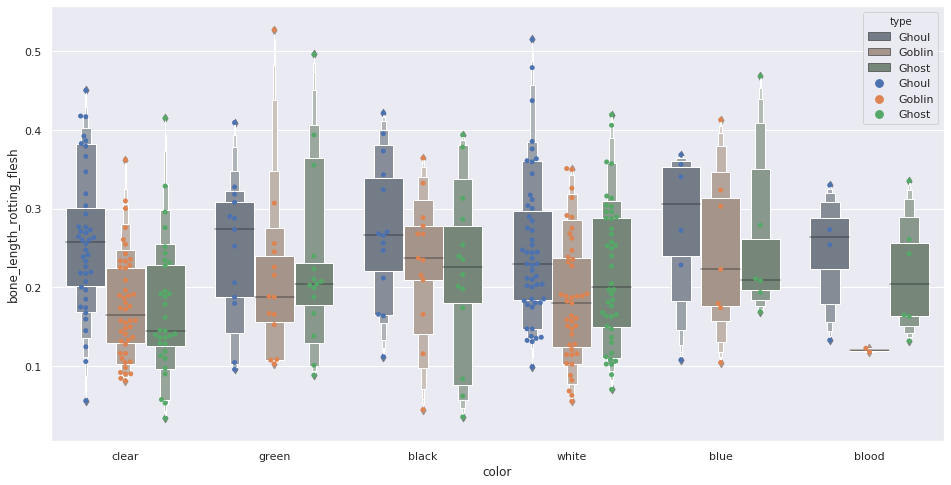

In [262]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh',
    hue='type',
    ax=ax,
    dodge=True,
);

In [263]:
lower_color_bone_length_rotting_flesh = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh.min()

lower_color_bone_length_rotting_flesh

color  type  
black  Ghost     0.035311
       Ghoul     0.111737
       Goblin    0.044535
blood  Ghost     0.131707
       Ghoul     0.132826
       Goblin    0.117870
blue   Ghost     0.169170
       Ghoul     0.107789
       Goblin    0.104392
clear  Ghost     0.033617
       Ghoul     0.055798
       Goblin    0.081192
green  Ghost     0.088308
       Ghoul     0.095634
       Goblin    0.102750
white  Ghost     0.070213
       Ghoul     0.098952
       Goblin    0.054970
Name: bone_length_rotting_flesh, dtype: float64

In [264]:
for color in lower_color_bone_length_rotting_flesh.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_lower'] = (train.color == color) & (train.bone_length_rotting_flesh < lcbl)

In [265]:
upper_color_bone_length_rotting_flesh = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh.max()

upper_color_bone_length_rotting_flesh

color  type  
black  Ghost     0.393846
       Ghoul     0.421424
       Goblin    0.364316
blood  Ghost     0.335264
       Ghoul     0.329876
       Goblin    0.122471
blue   Ghost     0.468233
       Ghoul     0.368337
       Goblin    0.412867
clear  Ghost     0.415070
       Ghoul     0.450243
       Goblin    0.361976
green  Ghost     0.495840
       Ghoul     0.409325
       Goblin    0.527259
white  Ghost     0.419263
       Ghoul     0.515027
       Goblin    0.350868
Name: bone_length_rotting_flesh, dtype: float64

In [266]:
for color in upper_color_bone_length_rotting_flesh.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_upper'] = (train.color == color) & (train.bone_length_rotting_flesh > ucbl)

#### `bone_length_hair_length`

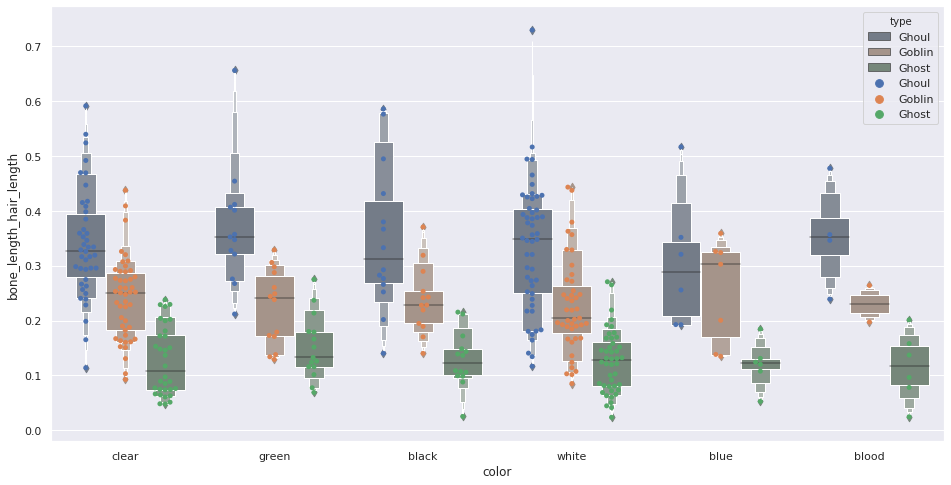

In [267]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [268]:
lower_color_bone_length_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_hair_length.min()

lower_color_bone_length_hair_length

color  type  
black  Ghost     0.025355
       Ghoul     0.140352
       Goblin    0.140261
blood  Ghost     0.024790
       Ghoul     0.239083
       Goblin    0.197457
blue   Ghost     0.052699
       Ghoul     0.192488
       Goblin    0.134912
clear  Ghost     0.048065
       Ghoul     0.114135
       Goblin    0.092711
green  Ghost     0.069032
       Ghoul     0.211943
       Goblin    0.129256
white  Ghost     0.023789
       Ghoul     0.116764
       Goblin    0.085308
Name: bone_length_hair_length, dtype: float64

In [269]:
for color in lower_color_bone_length_hair_length.index.levels[0]:
    lcbl = lower_color_bone_length_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_lower'] = (train.color == color) & (train.bone_length_hair_length < lcbl)

In [270]:
upper_color_bone_length_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_hair_length.max()

upper_color_bone_length_hair_length

color  type  
black  Ghost     0.215348
       Ghoul     0.585559
       Goblin    0.370493
blood  Ghost     0.201358
       Ghoul     0.477332
       Goblin    0.263880
blue   Ghost     0.184616
       Ghoul     0.516419
       Goblin    0.358685
clear  Ghost     0.238086
       Ghoul     0.591156
       Goblin    0.437274
green  Ghost     0.274952
       Ghoul     0.655573
       Goblin    0.328711
white  Ghost     0.270665
       Ghoul     0.729292
       Goblin    0.443054
Name: bone_length_hair_length, dtype: float64

In [271]:
for color in upper_color_bone_length_hair_length.index.levels[0]:
    ucbl = upper_color_bone_length_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_upper'] = (train.color == color) & (train.bone_length_hair_length > ucbl)

#### `bone_length_has_soul`

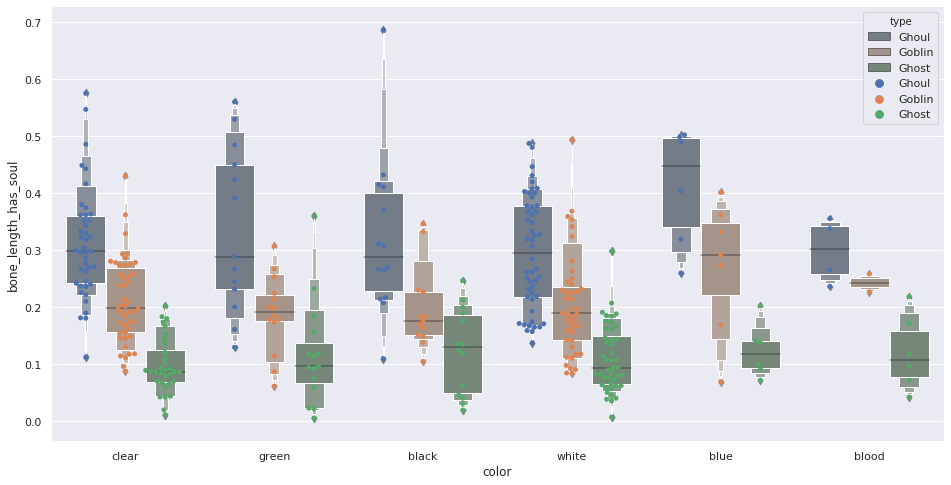

In [272]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [273]:
lower_color_bone_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_has_soul.min()

lower_color_bone_length_has_soul

color  type  
black  Ghost     0.018943
       Ghoul     0.109226
       Goblin    0.104476
blood  Ghost     0.041820
       Ghoul     0.236041
       Goblin    0.226772
blue   Ghost     0.071517
       Ghoul     0.259709
       Goblin    0.068713
clear  Ghost     0.010776
       Ghoul     0.111648
       Goblin    0.087475
green  Ghost     0.004859
       Ghoul     0.129145
       Goblin    0.060946
white  Ghost     0.006508
       Ghoul     0.136729
       Goblin    0.083560
Name: bone_length_has_soul, dtype: float64

In [274]:
for color in lower_color_bone_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_has_soul_lower'] = (train.color == color) & (train.bone_length_has_soul < lcbl)

In [275]:
upper_color_bone_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_has_soul.max()

upper_color_bone_length_has_soul

color  type  
black  Ghost     0.246322
       Ghoul     0.686921
       Goblin    0.346212
blood  Ghost     0.218181
       Ghoul     0.355080
       Goblin    0.257726
blue   Ghost     0.202301
       Ghoul     0.502254
       Goblin    0.401044
clear  Ghost     0.201804
       Ghoul     0.575552
       Goblin    0.430795
green  Ghost     0.360298
       Ghoul     0.560279
       Goblin    0.306682
white  Ghost     0.297915
       Ghoul     0.487252
       Goblin    0.493997
Name: bone_length_has_soul, dtype: float64

In [276]:
for color in upper_color_bone_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_has_soul_upper'] = (train.color == color) & (train.bone_length_has_soul > ucbl)

#### `rotting_flesh_hair_length`

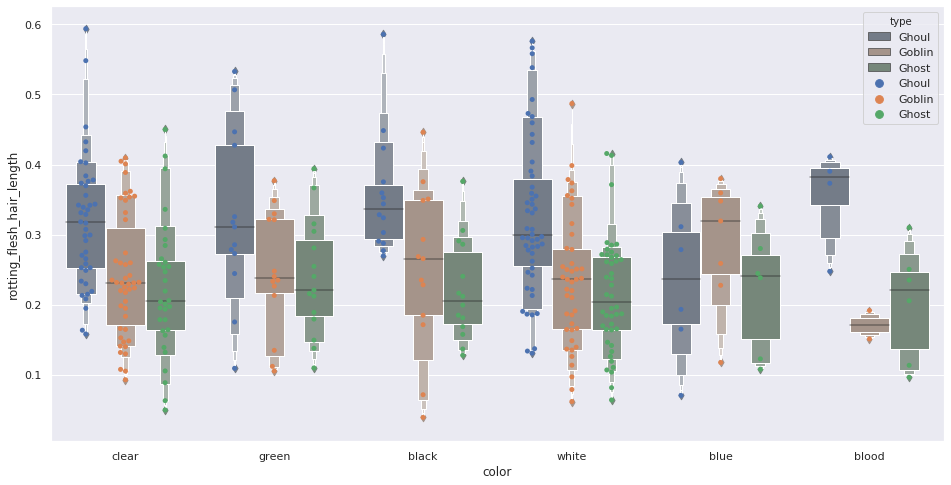

In [277]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [278]:
lower_color_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length.min()

lower_color_rotting_flesh_hair_length

color  type  
black  Ghost     0.127677
       Ghoul     0.269717
       Goblin    0.038924
blood  Ghost     0.096257
       Ghoul     0.247449
       Goblin    0.150990
blue   Ghost     0.107816
       Ghoul     0.070323
       Goblin    0.117388
clear  Ghost     0.049580
       Ghoul     0.158021
       Goblin    0.092726
green  Ghost     0.109540
       Ghoul     0.109019
       Goblin    0.105146
white  Ghost     0.063883
       Ghoul     0.130677
       Goblin    0.061614
Name: rotting_flesh_hair_length, dtype: float64

In [279]:
for color in lower_color_rotting_flesh_hair_length.index.levels[0]:
    lcbl = lower_color_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_lower'] = (train.color == color) & (train.rotting_flesh_hair_length < lcbl)

In [280]:
upper_color_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length.max()

upper_color_rotting_flesh_hair_length

color  type  
black  Ghost     0.375985
       Ghoul     0.585939
       Goblin    0.446057
blood  Ghost     0.309963
       Ghoul     0.411005
       Goblin    0.191550
blue   Ghost     0.340603
       Ghoul     0.402933
       Goblin    0.379852
clear  Ghost     0.450047
       Ghoul     0.593954
       Goblin    0.409465
green  Ghost     0.393996
       Ghoul     0.532806
       Goblin    0.376959
white  Ghost     0.415700
       Ghoul     0.576229
       Goblin    0.487073
Name: rotting_flesh_hair_length, dtype: float64

In [281]:
for color in upper_color_rotting_flesh_hair_length.index.levels[0]:
    ucbl = upper_color_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_upper'] = (train.color == color) & (train.rotting_flesh_hair_length > ucbl)

#### `rotting_flesh_has_soul`

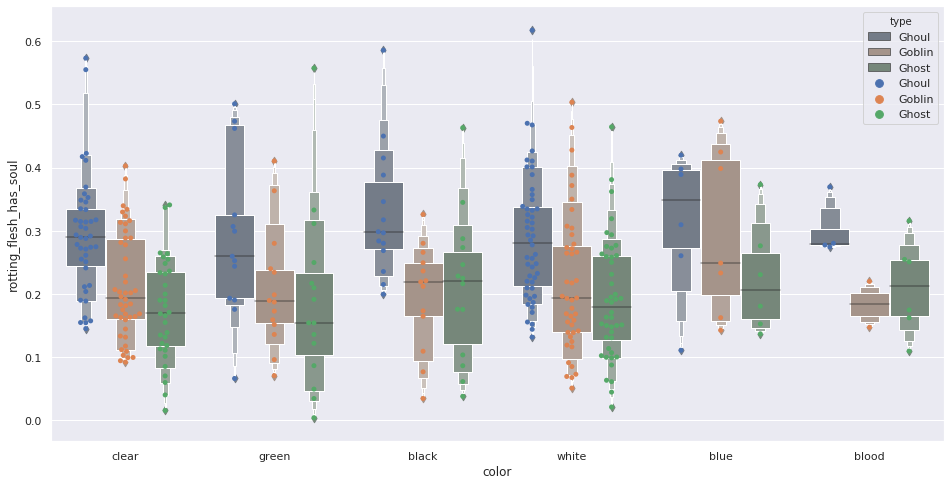

In [282]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [283]:
lower_color_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_has_soul.min()

lower_color_rotting_flesh_has_soul

color  type  
black  Ghost     0.038222
       Ghoul     0.199690
       Goblin    0.034863
blood  Ghost     0.109781
       Ghoul     0.274588
       Goblin    0.147469
blue   Ghost     0.137084
       Ghoul     0.111047
       Goblin    0.142823
clear  Ghost     0.015814
       Ghoul     0.145421
       Goblin    0.092267
green  Ghost     0.004360
       Ghoul     0.066430
       Goblin    0.071000
white  Ghost     0.021368
       Ghoul     0.131870
       Goblin    0.051222
Name: rotting_flesh_has_soul, dtype: float64

In [284]:
for color in lower_color_rotting_flesh_has_soul.index.levels[0]:
    lcbl = lower_color_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_has_soul_lower'] = (train.color == color) & (train.rotting_flesh_has_soul < lcbl)

In [285]:
upper_color_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_has_soul.max()

upper_color_rotting_flesh_has_soul

color  type  
black  Ghost     0.463205
       Ghoul     0.585818
       Goblin    0.325886
blood  Ghost     0.315979
       Ghoul     0.369527
       Goblin    0.219988
blue   Ghost     0.373232
       Ghoul     0.419637
       Goblin    0.473521
clear  Ghost     0.341016
       Ghoul     0.573259
       Goblin    0.402745
green  Ghost     0.557432
       Ghoul     0.500946
       Goblin    0.410463
white  Ghost     0.464496
       Ghoul     0.617408
       Goblin    0.503476
Name: rotting_flesh_has_soul, dtype: float64

In [286]:
for color in upper_color_rotting_flesh_has_soul.index.levels[0]:
    ucbl = upper_color_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_has_soul_upper'] = (train.color == color) & (train.rotting_flesh_has_soul > ucbl)

#### `hair_length_has_soul`

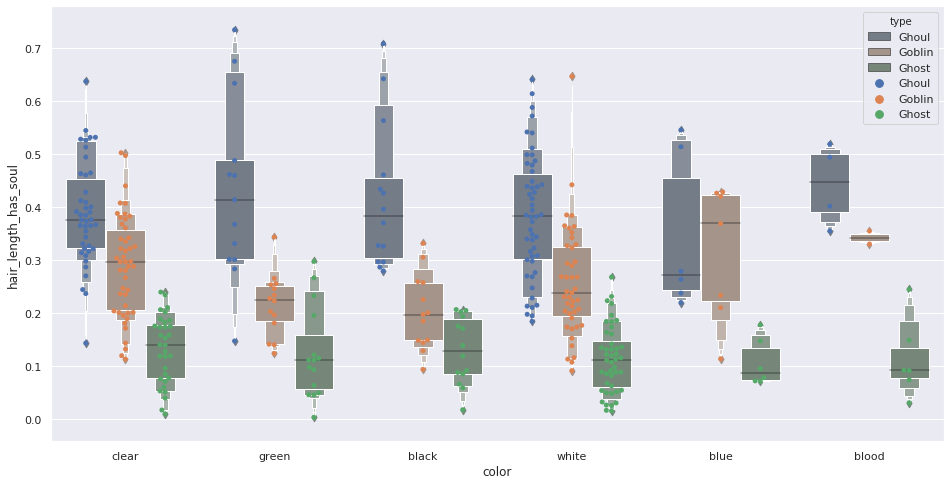

In [287]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [288]:
lower_color_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).hair_length_has_soul.min()

lower_color_hair_length_has_soul

color  type  
black  Ghost     0.017413
       Ghoul     0.279579
       Goblin    0.093500
blood  Ghost     0.030563
       Ghoul     0.354866
       Goblin    0.330144
blue   Ghost     0.071014
       Ghoul     0.219812
       Goblin    0.113622
clear  Ghost     0.009476
       Ghoul     0.143227
       Goblin    0.112865
green  Ghost     0.003026
       Ghoul     0.147220
       Goblin    0.123740
white  Ghost     0.015193
       Ghoul     0.184167
       Goblin    0.091167
Name: hair_length_has_soul, dtype: float64

In [289]:
for color in lower_color_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_has_soul_lower'] = (train.color == color) & (train.hair_length_has_soul < lcbl)

In [290]:
upper_color_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).hair_length_has_soul.max()

upper_color_hair_length_has_soul

color  type  
black  Ghost     0.206514
       Ghoul     0.708692
       Goblin    0.331412
blood  Ghost     0.244489
       Ghoul     0.518823
       Goblin    0.354683
blue   Ghost     0.177603
       Ghoul     0.545641
       Goblin    0.428614
clear  Ghost     0.239476
       Ghoul     0.637381
       Goblin    0.502495
green  Ghost     0.297361
       Ghoul     0.734639
       Goblin    0.343437
white  Ghost     0.267823
       Ghoul     0.640849
       Goblin    0.646879
Name: hair_length_has_soul, dtype: float64

In [291]:
for color in upper_color_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_hair_length_has_soul_upper'] = (train.color == color) & (train.hair_length_has_soul > ucbl)

### 3-way

#### `bone_length_rotting_flesh_hair_length`

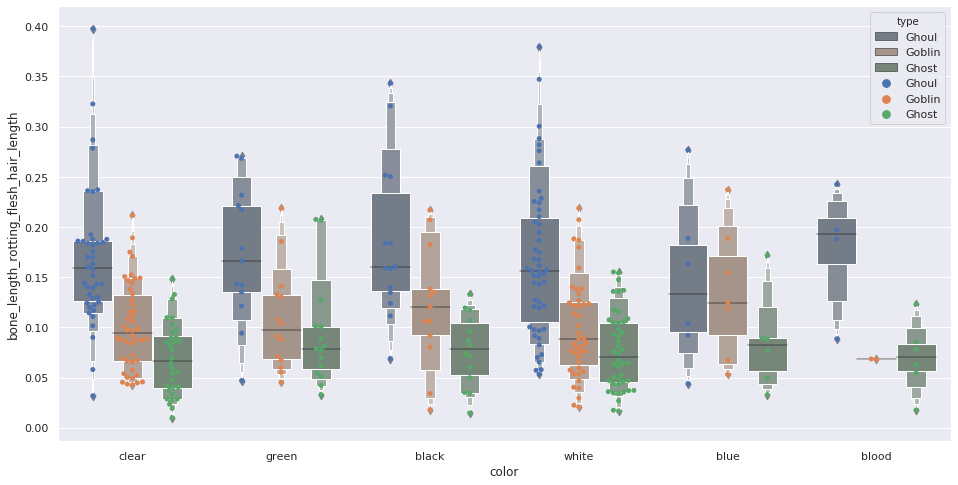

In [292]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length',
    hue='type',
    ax=ax,
    dodge=True,
);

In [293]:
lower_color_bone_length_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length.min()

lower_color_bone_length_rotting_flesh_hair_length

color  type  
black  Ghost     0.014670
       Ghoul     0.068925
       Goblin    0.018116
blood  Ghost     0.017728
       Ghoul     0.088646
       Goblin    0.068060
blue   Ghost     0.033050
       Ghoul     0.044023
       Goblin    0.053147
clear  Ghost     0.010068
       Ghoul     0.031723
       Goblin    0.042806
green  Ghost     0.033062
       Ghoul     0.047007
       Goblin    0.045356
white  Ghost     0.016547
       Ghoul     0.053164
       Goblin    0.020738
Name: bone_length_rotting_flesh_hair_length, dtype: float64

In [294]:
for color in lower_color_bone_length_rotting_flesh_hair_length.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length < lcbl)

In [295]:
upper_color_bone_length_rotting_flesh_hair_length = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length.max()

upper_color_bone_length_rotting_flesh_hair_length

color  type  
black  Ghost     0.132906
       Ghoul     0.343102
       Goblin    0.216961
blood  Ghost     0.123052
       Ghoul     0.242411
       Goblin    0.068530
blue   Ghost     0.171589
       Ghoul     0.276847
       Goblin    0.237175
clear  Ghost     0.148304
       Ghoul     0.397604
       Goblin    0.211551
green  Ghost     0.207555
       Ghoul     0.270566
       Goblin    0.218715
white  Ghost     0.155183
       Ghoul     0.379716
       Goblin    0.218742
Name: bone_length_rotting_flesh_hair_length, dtype: float64

In [296]:
for color in upper_color_bone_length_rotting_flesh_hair_length.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_hair_length.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length > ucbl)

#### `bone_length_rotting_flesh_has_soul`

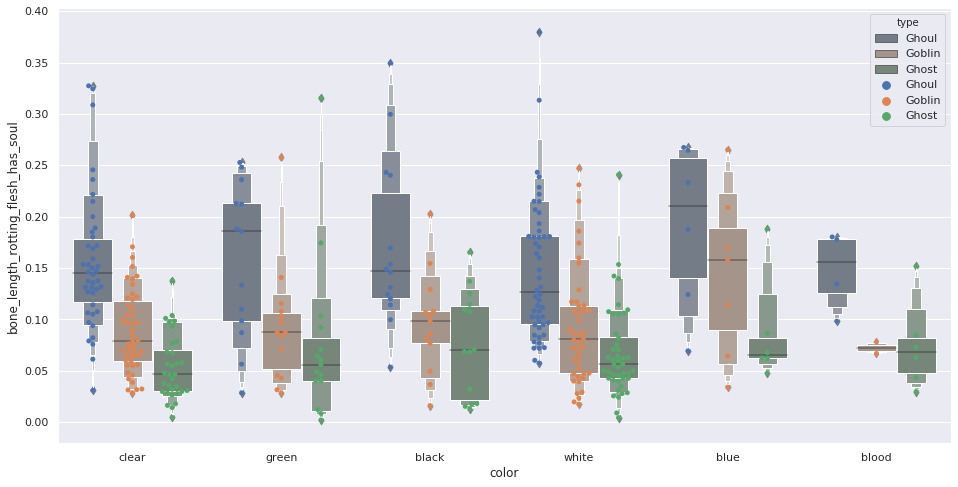

In [297]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [298]:
lower_color_bone_length_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_has_soul.min()

lower_color_bone_length_rotting_flesh_has_soul

color  type  
black  Ghost     0.013054
       Ghoul     0.053639
       Goblin    0.016226
blood  Ghost     0.029906
       Ghoul     0.098368
       Goblin    0.066932
blue   Ghost     0.048008
       Ghoul     0.069517
       Goblin    0.034158
clear  Ghost     0.004674
       Ghoul     0.031032
       Goblin    0.028780
green  Ghost     0.002253
       Ghoul     0.028643
       Goblin    0.028803
white  Ghost     0.004527
       Ghoul     0.057666
       Goblin    0.017737
Name: bone_length_rotting_flesh_has_soul, dtype: float64

In [299]:
for color in lower_color_bone_length_rotting_flesh_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_has_soul_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_has_soul < lcbl)

In [300]:
upper_color_bone_length_rotting_flesh_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_has_soul.max()

upper_color_bone_length_rotting_flesh_has_soul

color  type  
black  Ghost     0.165364
       Ghoul     0.349452
       Goblin    0.202742
blood  Ghost     0.152031
       Ghoul     0.180326
       Goblin    0.078165
blue   Ghost     0.188027
       Ghoul     0.267398
       Goblin    0.265184
clear  Ghost     0.137769
       Ghoul     0.327363
       Goblin    0.201670
green  Ghost     0.315571
       Ghoul     0.252777
       Goblin    0.257628
white  Ghost     0.240869
       Ghoul     0.379644
       Goblin    0.247166
Name: bone_length_rotting_flesh_has_soul, dtype: float64

In [301]:
for color in upper_color_bone_length_rotting_flesh_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_has_soul_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_has_soul > ucbl)

#### `bone_length_hair_length_has_soul`

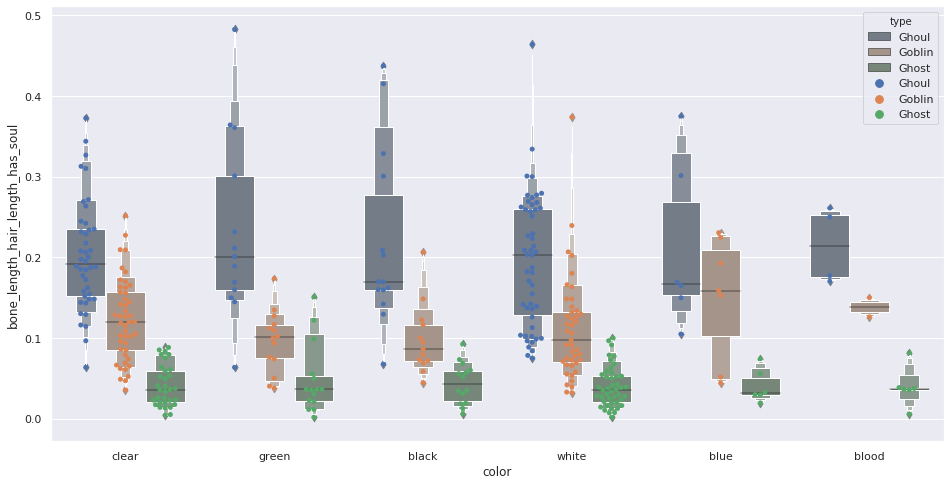

In [302]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [303]:
lower_color_bone_length_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_hair_length_has_soul.min()

lower_color_bone_length_hair_length_has_soul

color  type  
black  Ghost     0.005947
       Ghoul     0.067376
       Goblin    0.044574
blood  Ghost     0.005629
       Ghoul     0.170271
       Goblin    0.126023
blue   Ghost     0.019388
       Ghoul     0.104826
       Goblin    0.044145
clear  Ghost     0.004218
       Ghoul     0.063476
       Goblin    0.035480
green  Ghost     0.001564
       Ghoul     0.063479
       Goblin    0.037760
white  Ghost     0.001534
       Ghoul     0.074925
       Goblin    0.032133
Name: bone_length_hair_length_has_soul, dtype: float64

In [304]:
for color in lower_color_bone_length_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_has_soul_lower'] = (train.color == color) & (train.bone_length_hair_length_has_soul < lcbl)

In [305]:
upper_color_bone_length_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_hair_length_has_soul.max()

upper_color_bone_length_hair_length_has_soul

color  type  
black  Ghost     0.092444
       Ghoul     0.437408
       Goblin    0.206180
blood  Ghost     0.081392
       Ghoul     0.260932
       Goblin    0.149842
blue   Ghost     0.074135
       Ghoul     0.374899
       Goblin    0.230383
clear  Ghost     0.088173
       Ghoul     0.372577
       Goblin    0.251493
green  Ghost     0.150818
       Ghoul     0.482434
       Goblin    0.173565
white  Ghost     0.099980
       Ghoul     0.463782
       Goblin    0.373773
Name: bone_length_hair_length_has_soul, dtype: float64

In [306]:
for color in upper_color_bone_length_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_hair_length_has_soul_upper'] = (train.color == color) & (train.bone_length_hair_length_has_soul > ucbl)

#### `rotting_flesh_hair_length_has_soul`

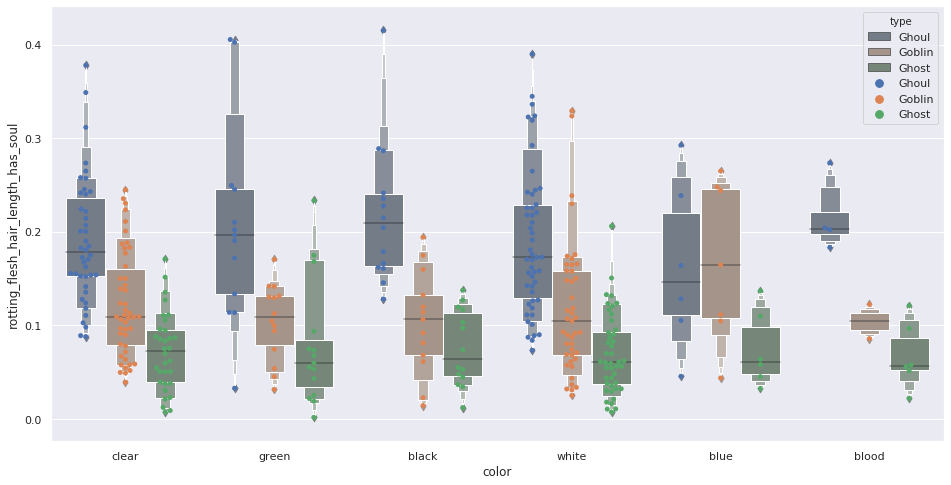

In [307]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [308]:
lower_color_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length_has_soul.min()

lower_color_rotting_flesh_hair_length_has_soul

color  type  
black  Ghost     0.012000
       Ghoul     0.128063
       Goblin    0.014182
blood  Ghost     0.021857
       Ghoul     0.183255
       Goblin    0.085739
blue   Ghost     0.032397
       Ghoul     0.045354
       Goblin    0.043646
clear  Ghost     0.007316
       Ghoul     0.087883
       Goblin    0.039112
green  Ghost     0.001403
       Ghoul     0.032652
       Goblin    0.031341
white  Ghost     0.007237
       Ghoul     0.073130
       Goblin    0.024883
Name: rotting_flesh_hair_length_has_soul, dtype: float64

In [309]:
for color in lower_color_rotting_flesh_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_has_soul_lower'] = (train.color == color) & (train.rotting_flesh_hair_length_has_soul < lcbl)

In [310]:
upper_color_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).rotting_flesh_hair_length_has_soul.max()

upper_color_rotting_flesh_hair_length_has_soul

color  type  
black  Ghost     0.137472
       Ghoul     0.415250
       Goblin    0.194075
blood  Ghost     0.120997
       Ghoul     0.273550
       Goblin    0.122253
blue   Ghost     0.136775
       Ghoul     0.292513
       Goblin    0.264935
clear  Ghost     0.170907
       Ghoul     0.378019
       Goblin    0.244772
green  Ghost     0.233337
       Ghoul     0.405430
       Goblin    0.170266
white  Ghost     0.205965
       Ghoul     0.390103
       Goblin    0.329242
Name: rotting_flesh_hair_length_has_soul, dtype: float64

In [311]:
for color in upper_color_rotting_flesh_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_rotting_flesh_hair_length_has_soul_upper'] = (train.color == color) & (train.rotting_flesh_hair_length_has_soul > ucbl)

### 4-way

#### `bone_length_rotting_flesh_hair_length_has_soul`

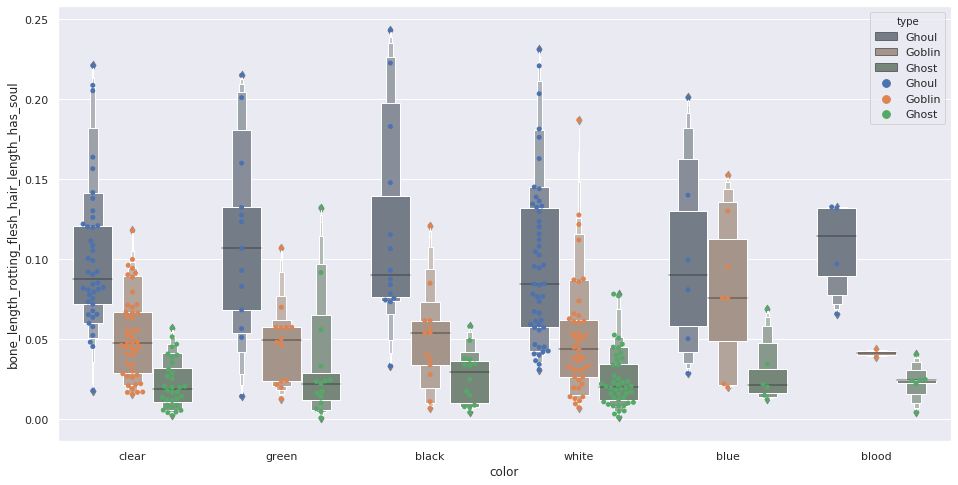

In [312]:
fig, ax = plt.subplots(figsize=(16,8))

sns.boxenplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    saturation=0.2,
)

sns.swarmplot(
    data=train,
    x='color',
    y='bone_length_rotting_flesh_hair_length_has_soul',
    hue='type',
    ax=ax,
    dodge=True,
);

In [313]:
lower_color_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.min()

lower_color_bone_length_rotting_flesh_hair_length_has_soul

color  type  
black  Ghost     0.004098
       Ghoul     0.033087
       Goblin    0.006601
blood  Ghost     0.004025
       Ghoul     0.065649
       Goblin    0.038914
blue   Ghost     0.012159
       Ghoul     0.028392
       Goblin    0.019760
clear  Ghost     0.002162
       Ghoul     0.017643
       Goblin    0.015710
green  Ghost     0.000725
       Ghoul     0.014079
       Goblin    0.012714
white  Ghost     0.001067
       Ghoul     0.030841
       Goblin    0.007078
Name: bone_length_rotting_flesh_hair_length_has_soul, dtype: float64

In [314]:
for color in lower_color_bone_length_rotting_flesh_hair_length_has_soul.index.levels[0]:
    lcbl = lower_color_bone_length_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_has_soul_lower'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length_has_soul < lcbl)

In [315]:
upper_color_bone_length_rotting_flesh_hair_length_has_soul = train.groupby([
    'color',
    'type',
]).bone_length_rotting_flesh_hair_length_has_soul.max()

upper_color_bone_length_rotting_flesh_hair_length_has_soul

color  type  
black  Ghost     0.057976
       Ghoul     0.243153
       Goblin    0.120739
blood  Ghost     0.040280
       Ghoul     0.132514
       Goblin    0.043438
blue   Ghost     0.068904
       Ghoul     0.200980
       Goblin    0.152337
clear  Ghost     0.056992
       Ghoul     0.220969
       Goblin    0.117863
green  Ghost     0.132096
       Ghoul     0.214896
       Goblin    0.106868
white  Ghost     0.078022
       Ghoul     0.231013
       Goblin    0.187013
Name: bone_length_rotting_flesh_hair_length_has_soul, dtype: float64

In [316]:
for color in upper_color_bone_length_rotting_flesh_hair_length_has_soul.index.levels[0]:
    ucbl = upper_color_bone_length_rotting_flesh_hair_length_has_soul.loc[color].sort_values().iloc[1]
    train[f'{color}_bone_length_rotting_flesh_hair_length_has_soul_upper'] = (train.color == color) & (train.bone_length_rotting_flesh_hair_length_has_soul > ucbl)

## Heatmaps for Booleans?

In [317]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type,black,blood,blue,...,blue_bone_length_rotting_flesh_hair_length_has_soul_lower,clear_bone_length_rotting_flesh_hair_length_has_soul_lower,green_bone_length_rotting_flesh_hair_length_has_soul_lower,white_bone_length_rotting_flesh_hair_length_has_soul_lower,black_bone_length_rotting_flesh_hair_length_has_soul_upper,blood_bone_length_rotting_flesh_hair_length_has_soul_upper,blue_bone_length_rotting_flesh_hair_length_has_soul_upper,clear_bone_length_rotting_flesh_hair_length_has_soul_upper,green_bone_length_rotting_flesh_hair_length_has_soul_upper,white_bone_length_rotting_flesh_hair_length_has_soul_upper
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,1,0,0,...,False,False,False,False,False,False,False,False,False,False
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul,1,0,0,...,False,False,False,False,True,False,False,False,False,False
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost,0,0,0,...,False,False,False,False,False,False,False,False,False,False


# Deviations From Normality

In [27]:
# flag bone_length within/outside +/-1 std of mean
train['bone_length_std1'] = train.bone_length.apply(
    lambda x : -1 if x < (train.bone_length.mean() - train.bone_length.std())
    else 1 if x > (train.bone_length.mean() + train.bone_length.std())
    else 0,
)

# flag rotting_flesh within/outside +/-1 std of mean
train['rotting_flesh_std1'] = train.rotting_flesh.apply(
    lambda x : -1 if x < (train.rotting_flesh.mean() - train.rotting_flesh.std())
    else 1 if x > (train.rotting_flesh.mean() + train.rotting_flesh.std())
    else 0,
)

# flag hair_length within/outside +/-1 std of mean
train['hair_length_std1'] = train.hair_length.apply(
    lambda x : -1 if x < (train.hair_length.mean() - train.hair_length.std())
    else 1 if x > (train.hair_length.mean() + train.hair_length.std())
    else 0,
)

# flag has_soul within/outside +/-1 std of mean
train['has_soul_std1'] = train.has_soul.apply(
    lambda x : -1 if x < (train.has_soul.mean() - train.has_soul.std())
    else 1 if x > (train.has_soul.mean() + train.has_soul.std())
    else 0,
)

# Polynomials

In [28]:
# define poly
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# fit_transform train data
poly_numeric = poly.fit_transform(train.drop(columns=[
    'id',
    'type',
    'color',
]))

# redefine train with new poly features
train = train.loc[:, [
    'id',
    'type',
    'color',
]].join(pd.DataFrame(
    data=poly_numeric,
    columns=poly.get_feature_names(train.drop(columns=[
        'id',
        'type',
        'color',
    ]).columns.tolist())
))

# Scaling

In [29]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = pd.DataFrame(
    data=scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

X_r = pd.DataFrame(
    data=rscaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# Variance Threshold

In [30]:
# redefine variance threshold (in case it wasn't previously)
vt = VarianceThreshold(threshold=0.0)

# redefine X_ based on vt
X_ = pd.DataFrame(
    data=vt.fit_transform(X_),
    index=X_.index,
    columns=X_.columns[vt.get_support()]
)

# redefine X_r based on vt
X_r = pd.DataFrame(
    data=vt.fit_transform(X_r),
    index=X_r.index,
    columns=X_r.columns[vt.get_support()]
)

# Percentile Selection
##### Using [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

In [32]:
# define selector
selector = SelectPercentile(
    score_func=mutual_info_classif,
    percentile=10
)

# keep top 10 percent of features
X_ = pd.DataFrame(
    data=selector.fit_transform(X_, y),
    index=X_.index,
    columns=X_.columns[selector.get_support()]
)

# keep top 10 percent of features
X_r = pd.DataFrame(
    data=selector.fit_transform(X_r, y),
    index=X_r.index,
    columns=X_r.columns[selector.get_support()]
)

# Feature Importance

In [ ]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

In [ ]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_r, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_r.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

# Top n per FI

In [ ]:
# top features per fi-algorithm
n = 1

sns.pairplot(
    data=X.join(y),
    hue='type',
    vars=list(set(fi.iloc[0].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[1].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[2].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[3].sort_values(ascending=False).head(n).index.tolist()))
);

The most important feature from all three ensemble algorithms is `hair_length`.

# Model

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X_r, y, test_size=0.1, random_state=0)

In [ ]:
results = {}

for k,v in classifiers.items():
    
    print(k)
    
    cv = cross_validate(
        estimator=v,
        X=train_x,
        y=train_y,
        cv=10
    )
    
    cv = cv['test_score']
    
    results[k] = cv

In [ ]:
# selector 10
pd.DataFrame.from_dict(results, orient='columns').describe()

# GridSearchCV

## AdaBoostClassifier

In [ ]:
AdaBoostClassifier_g = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid={
        'n_estimators' : np.arange(50, 250, 5),
        'learning_rate' : np.arange(1e-2, 1e1, 1e-1),
        'algorithm' : ['SAMME', 'SAMME.R'],
        'random_state' : [0]
    },
    cv=10
)

AdaBoostClassifier_g.fit(train_x, train_y)

print(f"AdaBoostClassifier_g.best_score_: {AdaBoostClassifier_g.best_score_}")

In [ ]:
scores = cross_val_score(
    estimator=AdaBoostClassifier_g.best_estimator_,
    X=train_x,
    y=train_y,
    cv=10
)

print(pd.Series(scores).describe())

pd.Series(scores).plot.kde();

## ExtraTreesClassifier

In [ ]:
ExtraTreesClassifier_g = GridSearchCV(
    estimator=ExtraTreesClassifier(),
    param_grid={
        'n_estimators' : np.arange(50, 250, 5),
        'learning_rate' : np.arange(1e-2, 1e1, 1e-1),
        'algorithm' : ['SAMME', 'SAMME.R'],
        'random_state' : [0]
    },
    cv=10
)

AdaBoostClassifier_g.fit(train_x, train_y)

print(f"AdaBoostClassifier_g.best_score_: {AdaBoostClassifier_g.best_score_}")

## LogisticRegression

In [ ]:
LogisticRegression_g = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'random_state' : [0],
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(1e-2, 1e1, 1e-1),
        'fit_intercept' : [True],
        'max_iter' : [200],
        'solver' : ['liblinear'],
        'multi_class' : ['auto'],
    },
    cv=10,
)

LogisticRegression_g.fit(train_x, train_y)

print(f"LogisticRegression_g.best_score_: {LogisticRegression_g.best_score_}")

In [ ]:
scores = cross_val_score(
    estimator=LogisticRegression_g.best_estimator_,
    X=train_x,
    y=train_y,
    cv=10
)

print(pd.Series(scores).describe())

pd.Series(scores).plot.kde();

In [ ]:
pd.DataFrame(classification_report(
    y_true=test_y,
    y_pred=LogisticRegression_g.best_estimator_.predict(test_x),
    output_dict=True
))